# Multivariate Forecasting Models

In a previous notebook, we explored some simple univariate forecasting models to forecast the values of each SMART metric individually. However, Ceph subject matter experts believe that there may be some interactions or interdependencies across various SMART metrics. That is, it may be possible to better predict a particular metric, given the time series of the other metrics. Therefore, this notebook briefly extends the univariate forecasting exploration to the multivariate domain.

**NOTE** Here, we will work with the cleaned up and preprocessed data created during the data clean up sections in the previous notebook.

Use the following variables to define the forecasting set up.

- `Y_COLS`: The metrics to forecast. Since previous research done in this project suggests that smart 5, 10, 187, 188, 197, 198 are valueable indicators of failure, we'll use these as the default.
- `X_COLS`: The other metrics available. We'll use the same metrics as above for this.
- `NDAYS_DATA`: How many days of data available in at runtime. Since the diskprediction_local module of ceph stores only 6 days of smart data, our models will only have that much data available.
- `NDAYS_TO_PREDICT`: How many days into the future to forecast. Since we have a short amount of historical data, we will be forecasting for a short period too.

In [1]:
# imports
import pdb
import warnings
from tqdm import tqdm
from copy import deepcopy
from functools import partial
from itertools import permutations
from IPython.display import display

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, TheilSenRegressor

from sklearn.utils._testing import ignore_warnings

In [2]:
# notebook display config
sns.set()
tqdm.pandas()

In [3]:
# set which columns are metadata and which ones are smart attribuetes
meta_cols = ["date", "serial_number", "model", "capacity_bytes", "failure"]

# set which columns to use in analysis
# NOTE: this determined based on backblaze research, ibm paper, and SMART wiki
smart_stats_to_keep = [
    5,
    10,
    187,
    188,
    197,
    198,
]
smart_cols = [f"smart_{i}_raw" for i in smart_stats_to_keep]
smart_cols += [f"smart_{i}_normalized" for i in smart_stats_to_keep]

In [4]:
# training setup config
X_COLS = deepcopy(smart_cols)
Y_COLS = deepcopy(smart_cols)

NDAYS_DATA = 6
NDAYS_TO_PREDICT = 6

MODELS = ["baseline", "var", "linreg", "wlinreg", "ridge", "theilsen", "dt", "rf"]

In [5]:
# read in cleaned data from previous notebook
# NOTE: we're only using failed drive timeseries because working drive timeseries dont have a lot of "fluctuations"
# or trends. Even the baseline methods achieve <0.25 MSE for working drives, so including that data would not
# contribute much, and rather worsen the class imbalance
failed_ts_df = pd.read_parquet(
    "../../data/interim/failed_ts_df_1612199672.650661.parquet"
)

In [6]:
# minor preprocessing - failed data

# keep only timeseries with enough data
ts_lengths = failed_ts_df.groupby("serial_number").size()
keep_serials = ts_lengths[ts_lengths > NDAYS_DATA]
failed_ts_df = failed_ts_df[failed_ts_df["serial_number"].isin(keep_serials.index)]

# convert index type to datetime instead of object
failed_ts_df.index = pd.DatetimeIndex(failed_ts_df.index)

failed_ts_df = failed_ts_df.groupby("serial_number").apply(
    # NOTE: ffill HAS TO BE CALLED after interpolate coz serial number and model
    # are strings and canot be interpolated so they stay nan after interpolate
    # if left nan, then during groupby-apply-trainmodel-calcualteloss that row
    # wont appear and therefore there wont be any point in resampling @ D
    lambda g: g.resample("D")
    .interpolate()
    .ffill()
)

# convert back serial number from index to external column
failed_ts_df.reset_index(level=0, drop=True, inplace=True)

# remove serial number from index, as it is already a colunm in df
if failed_ts_df.index.nlevels > 1:
    failed_ts_df.reset_index(level=0, drop=True, inplace=True)

## Will Adding More Metrics Really Help?

Although subject matter knowledge suggests that other metrics can be helpful in forecasting a particular metric, it would be a good idea to mathematically verify that this really holds true. In this section, we'll apply the Granger Causality test and see whether change in behavior of one metric's timeseries does in fact affect behavior of another metric's timeseries.

In [7]:
# granger test for each permuatation of smart metrics
feat_perms = [i for i in permutations(Y_COLS, 2)]


def apply_grangercausalitytests(drive_ts, perms, lags=6):
    """
    This bit of code is mostly taken from this blog post:
    https://rishi-a.github.io/2020/05/25/granger-causality.html
    """
    # too little data
    if len(drive_ts) < NDAYS_DATA:
        return np.nan

    resultsdf = pd.Series(index=perms, dtype=np.float)
    for i, c in enumerate(perms):
        # timeseries for the two metrics in question
        df = drive_ts.loc[:, c]

        try:
            # apply test and get minimum p-value for
            res = grangercausalitytests(df, maxlag=lags, verbose=False)
            p_values = [res[i + 1][0]["ssr_chi2test"][1] for i in range(lags)]
            resultsdf.iloc[i] = min(p_values)
        except ValueError:
            resultsdf.iloc[i] = np.nan

    return resultsdf


with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ret = failed_ts_df.groupby("serial_number").progress_apply(
        partial(apply_grangercausalitytests, perms=feat_perms)
    )

100%|██████████| 251/251 [00:35<00:00,  6.99it/s]


In [8]:
# lets look at, on average what is the pvalue
mean_pvals = ret.dropna(axis=1, how="all").dropna(axis=0, how="all").mean()
mean_pvals.sort_values().head(25)

(smart_198_normalized, smart_5_normalized)    0.000030
(smart_197_normalized, smart_5_normalized)    0.000030
(smart_197_normalized, smart_197_raw)         0.000469
(smart_198_normalized, smart_198_raw)         0.000469
(smart_198_normalized, smart_197_raw)         0.000469
(smart_197_normalized, smart_198_raw)         0.000469
(smart_198_raw, smart_198_normalized)         0.001619
(smart_198_raw, smart_197_normalized)         0.001619
(smart_197_raw, smart_198_normalized)         0.001619
(smart_197_raw, smart_197_normalized)         0.001619
(smart_5_normalized, smart_197_normalized)    0.009849
(smart_5_normalized, smart_198_normalized)    0.009849
(smart_5_normalized, smart_5_raw)             0.030481
(smart_187_raw, smart_198_normalized)         0.033370
(smart_187_raw, smart_197_normalized)         0.033370
(smart_5_normalized, smart_198_raw)           0.040780
(smart_5_normalized, smart_197_raw)           0.040780
(smart_198_normalized, smart_5_raw)           0.051934
(smart_197

### Conclusion
From the above results, we can see that average pvalue is <0.05 for several pairs of SMART metrics - (188, 5), (198, 5), (197, 5), (197, 198) (187, 197), etc. Therefore, we can reject the null hypotheses for these pairs. That is, there exists some interaction in the time series of these pairs. However, smart 10 does seem to appear in any combination that has a pvalue <0.05. This suggests that there is not a lot of value in including smart 10 in our multivariate setup. Hence, we'll remove it from further analysis.

In [9]:
# remove smart 10
Y_COLS.remove("smart_10_raw")
Y_COLS.remove("smart_10_normalized")
X_COLS.remove("smart_10_raw")
X_COLS.remove("smart_10_normalized")

## Helper Functions

In [10]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Slightly modified version of implementation at
    https://github.com/scikit-learn/scikit-learn/issues/18685
    """
    e_j = mean_absolute_error(y_true, y_pred, multioutput="raw_values")
    scale = mean_absolute_error(y_train[1:], y_train[:-1], multioutput="raw_values")
    #     return np.divide(e_j, scale, out=np.zeros_like(e_j), where=e_j!=0)
    return e_j / (1 + scale)

In [11]:
def mean_absolute_error_by_mean(y_true, y_pred, y_train):
    """
    Similar idea as MASE, but scaling by mean only instead
    of mean naive error
    """
    mae = mean_absolute_error(y_true, y_pred, multioutput="raw_values")
    #     return np.divide(mae, y_train.mean(), out=np.zeros_like(mae), where=mae!=0)
    return mae / (1 + y_train.mean())

In [12]:
def plot_losses_metricwise(results_df, ts_df, to_plot=15, loss_name="MAPE"):
    global Y_COLS

    # stds of each device time series
    device_ts_stds = (
        ts_df[Y_COLS + ["serial_number"]].groupby("serial_number").std(ddof=0)
    )

    for col in Y_COLS:
        # plot losses for devices where the timeseries had the most fluctuations
        sers = device_ts_stds[col].sort_values(ascending=False).index[:to_plot]
        results_df.loc[sers, col].unstack(level=0).plot(figsize=(15, 5))

        # plot details
        plt.title(f"{loss_name} over time for {col}")
        plt.ylabel(loss_name)
        plt.xticks(rotation=90)
        plt.show()

In [13]:
def calculate_predictionwindow_loss(y_true, y_pred, y_train=None, loss_name="mse"):
    if loss_name == "mase":
        return mean_absolute_scaled_error(
            y_true=y_true,
            y_pred=y_pred,
            y_train=y_train,
        )
    elif loss_name == "mape":
        return mean_absolute_percentage_error(
            y_true=y_true,
            y_pred=y_pred,
            multioutput="raw_values",
        )
    elif loss_name == "maebm":
        return mean_absolute_error_by_mean(
            y_true=y_true,
            y_pred=y_pred,
            y_train=y_train,
        )
    elif loss_name == "mse":
        try:
            ret = mean_squared_error(
                y_true=y_true,
                y_pred=y_pred,
                multioutput="raw_values",
            )
        except ValueError as ve:
            print(ve)
            print("Error too high. Returning infs")
            ret = [np.inf] * y_pred.shape[1]
        return ret
    else:
        raise NotImplementedError

### TODO
- ridge


- repeat for working drives


- figure out what to do with loss when value the y true value itself is 0


- if we confine context to only one smart metric at a time and only relative improvements then maybe using mse is also fine?
   - e.g. for smart 5 improvement in MSE is 1000, for smart 34 improvement in MSE is 2


- more baselines? drift? mean? seasonal naive?


- clip values at 10000 or something so other stuff in the graph is also visible

### QUESTION
- should error be calculated for the "shrinking" windows at the end? i.e. predict for next 3 days only even when NDAYS_TO_PREDICT=6, since disk died after 3 days.
    - would that be a fair assessment? we'd be predicting only for the next 1 day. disk death "censors" the observations that would have been there. MSE is averaged over only 3 days instead of 6 or more

## Baseline

In this section we will fit baseline models for the forecasting task. We will compare the performance of the ML models with this baseline to gauge how informative are the models. The baseline model here is one that predicts the next N days will be the same as today.

In [14]:
def get_baseline_windowwise_losses(drive_ts, loss="mse"):
    """
    Predict the next N days the value will be same as today.
    Calculate MSE at the end of each training window
    """
    losses = pd.DataFrame(
        columns=Y_COLS, index=deepcopy(drive_ts.index), dtype=np.float
    )

    # if train window slides beyond len(df)-1 then we wont
    # have any data to calculate loss
    for end_idx in range(NDAYS_DATA, len(drive_ts) - NDAYS_TO_PREDICT + 1):

        # smart metrics values on the last day
        last_day_data = drive_ts[Y_COLS].iloc[end_idx]

        # smart metrics values for next min(NDAYS_TO_PRED, df) days
        future_data = drive_ts[Y_COLS].iloc[end_idx : end_idx + NDAYS_TO_PREDICT]

        # calculate loss
        losses.iloc[end_idx - 1] = calculate_predictionwindow_loss(
            loss_name=loss,
            y_true=future_data,
            y_train=drive_ts[Y_COLS].iloc[end_idx - NDAYS_DATA : end_idx],
            y_pred=last_day_data.values.reshape(1, -1).repeat(
                axis=0,
                repeats=len(future_data),
            ),
        )

    return losses

In [15]:
# calculate pred=same_as_last_day baseline
failedts_baseline_losses = failed_ts_df.groupby("serial_number").progress_apply(
    get_baseline_windowwise_losses
)

# drop rows where there are no results (coz not enough historical data)
failedts_baseline_losses.dropna(axis=0, how="all", inplace=True)

# average mse across days
failedts_baseline_losses.mean(level=0)

100%|██████████| 251/251 [00:29<00:00,  8.56it/s]


,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_5_normalized,smart_187_normalized,smart_188_normalized,smart_197_normalized,smart_198_normalized
serial_number,,,,,,,,,,
S300Z4TZ,8.581553e+02,18.139269,0.178082,9.504205e+04,9.504205e+04,0.002283,18.139269,0.0,3.410959,3.410959
S300Z7P1,0.000000e+00,0.184932,0.000000,1.461187e-01,1.461187e-01,0.000000,0.184932,0.0,0.000000,0.000000
S301FDQW,5.148200e+06,251.022876,0.000000,3.144645e+06,3.144645e+06,3.169935,94.055556,0.0,93.513072,93.513072
S301GMWQ,7.111111e+01,24.000000,0.000000,8.533333e+01,8.533333e+01,0.000000,24.000000,0.0,0.000000,0.000000
S301GMY2,1.105455e+02,324.333333,0.000000,1.688388e+05,1.688388e+05,0.000000,286.878788,0.0,6.393939,6.393939
...,...,...,...,...,...,...,...,...,...,...
ZLW0EFTW,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0EFYY,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0G6CE,0.000000e+00,1136.678571,0.000000,0.000000e+00,0.000000e+00,0.000000,116.678571,0.0,0.000000,0.000000


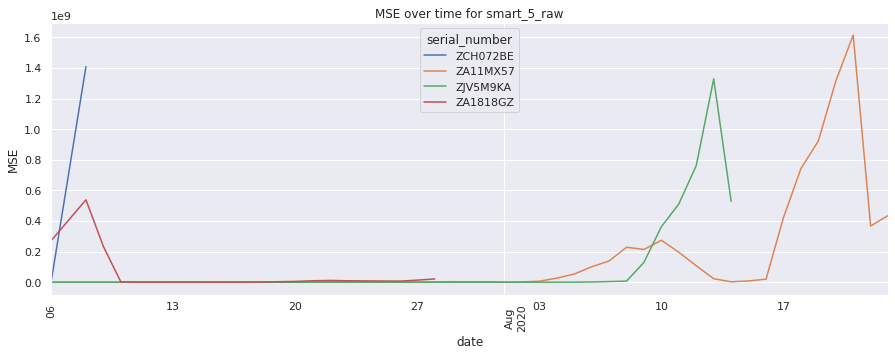

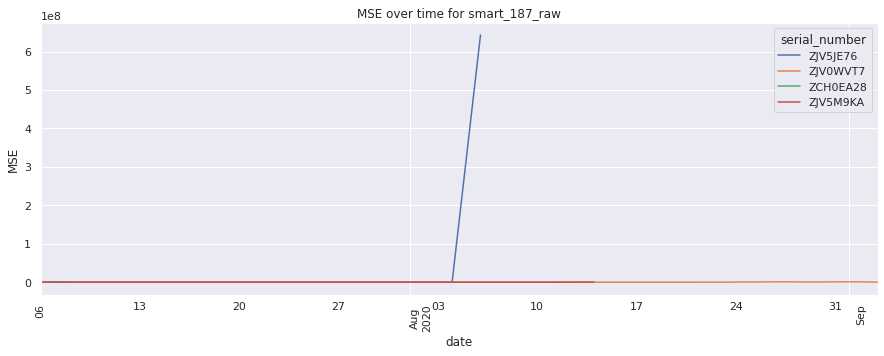

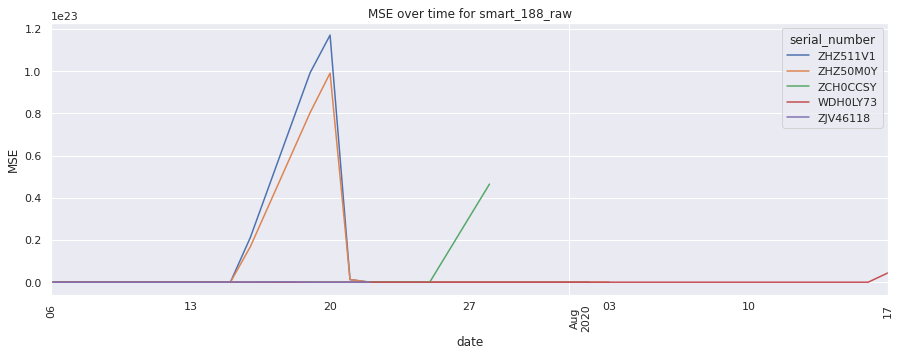

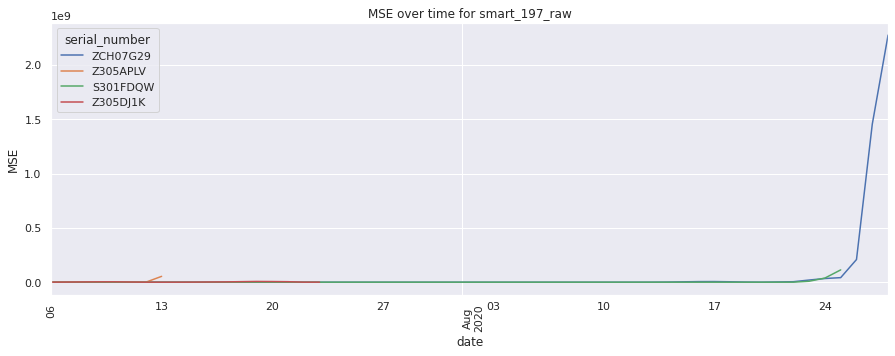

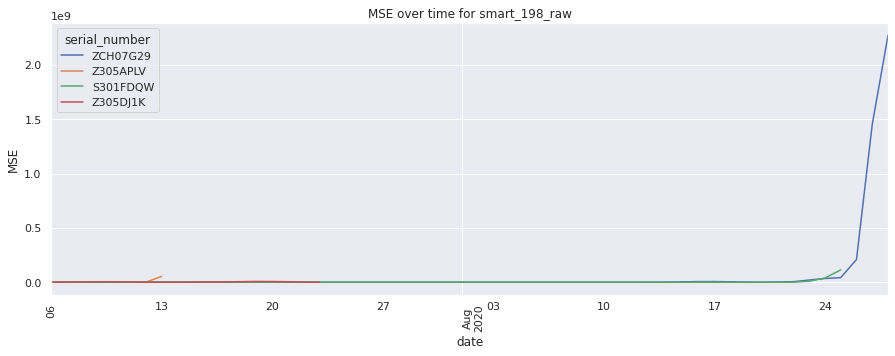

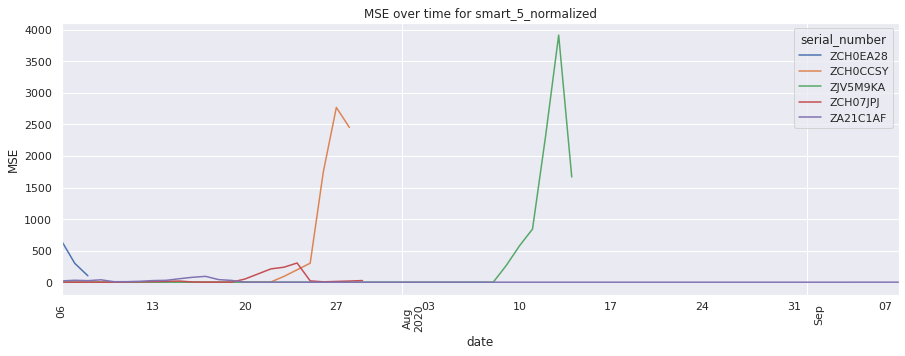

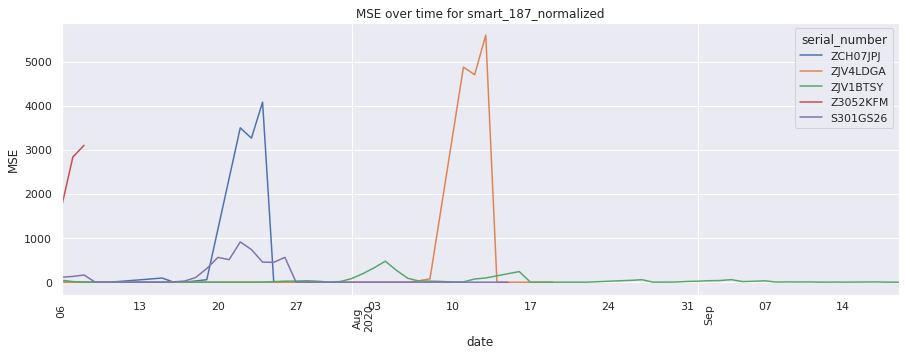

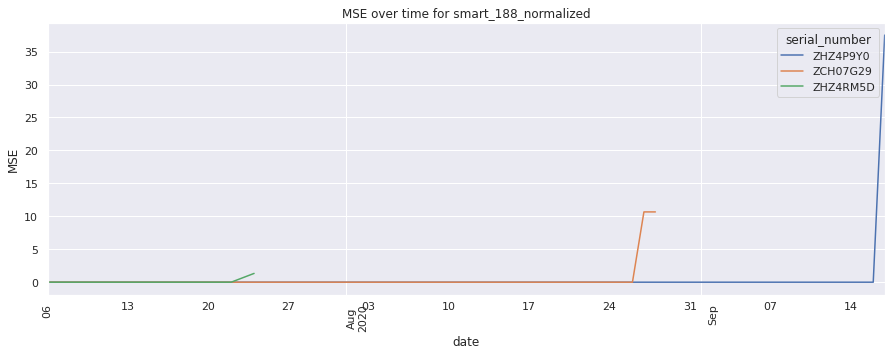

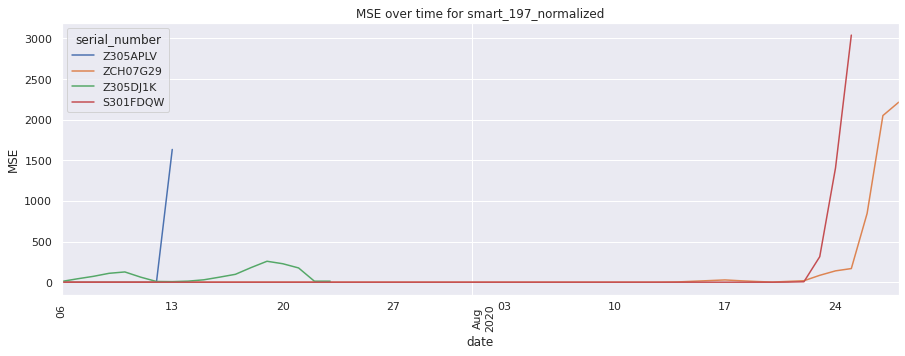

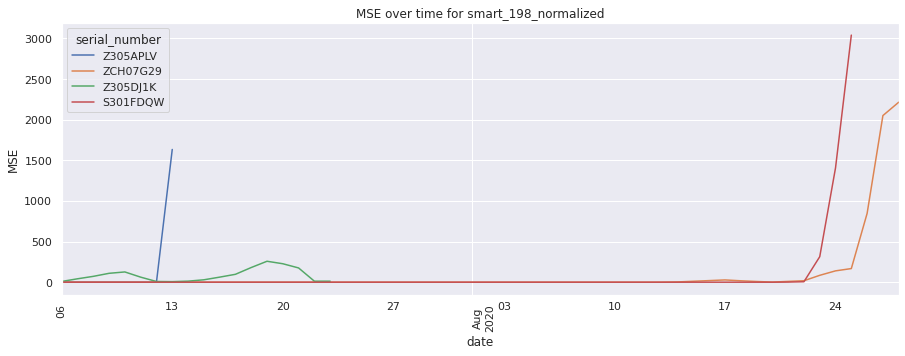

In [16]:
# visualize performance for time series with highest stds
plot_losses_metricwise(
    failedts_baseline_losses,
    failed_ts_df,
    loss_name="MSE",
    to_plot=5,
)

In [17]:
# multilevel index, columns df to store all results (raw / unaggregated)

# for easy indexing into multidim df
midx = pd.IndexSlice

# init df
all_losses = pd.DataFrame(
    index=failedts_baseline_losses.index,
    columns=pd.MultiIndex.from_product([Y_COLS, MODELS]),
)

# add baseline loss values
all_losses.loc[:, midx[:, "baseline"]] = failedts_baseline_losses.values
all_losses

smart_5_raw                                          \
                            baseline  var linreg wlinreg ridge theilsen   dt   
serial_number date                                                             
S300Z4TZ      2020-07-06         0.0  NaN    NaN     NaN   NaN      NaN  NaN   
              2020-07-07         0.0  NaN    NaN     NaN   NaN      NaN  NaN   
              2020-07-08         0.0  NaN    NaN     NaN   NaN      NaN  NaN   
              2020-07-09         0.0  NaN    NaN     NaN   NaN      NaN  NaN   
              2020-07-10         0.0  NaN    NaN     NaN   NaN      NaN  NaN   
...                              ...  ...    ...     ...   ...      ...  ...   
ZLW0GKE4      2020-08-10         0.0  NaN    NaN     NaN   NaN      NaN  NaN   
              2020-08-11         0.0  NaN    NaN     NaN   NaN      NaN  NaN   
              2020-08-12         0.0  NaN    NaN     NaN   NaN      NaN  NaN   
              2020-08-13         0.0  NaN    NaN     NaN   NaN      NaN  NaN   
              2020-08-14         0.0  NaN    NaN     NaN   NaN      NaN  NaN   

                              smart_187_raw       ... smart_197_normalized  \
                           rf      baseline  var  ...                   dt   
serial_number date                                ...                        
S300Z4TZ      2020-07-06  NaN           0.0  NaN  ...                  NaN   
              2020-07-07  NaN           0.0  NaN  ...                  NaN   
              2020-07-08  NaN           0.0  NaN  ...                  NaN   
              2020-07-09  NaN           0.0  NaN  ...                  NaN   
              2020-07-10  NaN           0.0  NaN  ...                  NaN   
...                       ...           ...  ...  ...                  ...   
ZLW0GKE4      2020-08-10  NaN           0.0  NaN  ...                  NaN   
              2020-08-11  NaN           0.0  NaN  ...                  NaN   
              2020-08-12  NaN           0.0  NaN  ...                  NaN   
              2020-08-13  NaN           0.0  NaN  ...                  NaN   
              2020-08-14  NaN           0.0  NaN  ...                  NaN   

                              smart_198_normalized                            \
                           rf             baseline  var linreg wlinreg ridge   
serial_number date                                                             
S300Z4TZ      2020-07-06  NaN                  0.0  NaN    NaN     NaN   NaN   
              2020-07-07  NaN                  0.0  NaN    NaN     NaN   NaN   
              2020-07-08  NaN                  0.0  NaN    NaN     NaN   NaN   
              2020-07-09  NaN                  0.0  NaN    NaN     NaN   NaN   
              2020-07-10  NaN                  0.0  NaN    NaN     NaN   NaN   
...                       ...                  ...  ...    ...     ...   ...   
ZLW0GKE4      2020-08-10  NaN                  0.0  NaN    NaN     NaN   NaN   
              2020-08-11  NaN                  0.0  NaN    NaN     NaN   NaN   
              2020-08-12  NaN                  0.0  NaN    NaN     NaN   NaN   
              2020-08-13  NaN                  0.0  NaN    NaN     NaN   NaN   
              2020-08-14  NaN                  0.0  NaN    NaN     NaN   NaN   

                                             
                         theilsen   dt   rf  
serial_number date                           
S300Z4TZ      2020-07-06      NaN  NaN  NaN  
              2020-07-07      NaN  NaN  NaN  
              2020-07-08      NaN  NaN  NaN  
              2020-07-09      NaN  NaN  NaN  
              2020-07-10      NaN  NaN  NaN  
...                           ...  ...  ...  
ZLW0GKE4      2020-08-10      NaN  NaN  NaN  
              2020-08-11      NaN  NaN  NaN  
              2020-08-12      NaN  NaN  NaN  
              2020-08-13      NaN  NaN  NaN  
              2020-08-14      NaN  NaN  NaN  

[8964 rows x 80 columns]

In [18]:
# mean and median loss for each train-predict window for each metric

# average value of "average loss foreach disk"
print("Average Value of Mean Loss in each Disk")
display(all_losses.mean(level=0).mean())

# average value of "median loss foreach disk"
print("Average Value of Median Loss in each Disk")
display(all_losses.median(level=0).mean())

Average Value of Mean Loss in each Disk


smart_5_raw           baseline    1.070717e+07
smart_187_raw         baseline    1.323396e+05
smart_188_raw         baseline    1.185425e+20
smart_197_raw         baseline    3.864570e+05
smart_198_raw         baseline    3.864570e+05
smart_5_normalized    baseline    4.996652e+00
smart_187_normalized  baseline    4.591539e+01
smart_188_normalized  baseline    4.378616e-03
smart_197_normalized  baseline    2.244994e+00
smart_198_normalized  baseline    2.244994e+00
dtype: float64

Average Value of Median Loss in each Disk


smart_5_raw           baseline    4.350559e+06
smart_187_raw         baseline    3.380196e+02
smart_188_raw         baseline    7.352188e+16
smart_197_raw         baseline    8.916220e+03
smart_198_raw         baseline    8.916220e+03
smart_5_normalized    baseline    1.378261e+00
smart_187_normalized  baseline    1.763986e+01
smart_188_normalized  baseline    0.000000e+00
smart_197_normalized  baseline    3.362319e-01
smart_198_normalized  baseline    3.362319e-01
dtype: float64

## AR/MA Models

In this section we will explore autoregressive and moving average families of models.

### VAR

In [19]:
def get_var_windowwise_losses(drive_ts, loss="mse"):
    """
    Fit VAR model and calculate loss
    for each train_ts-predict window the given drive
    """
    losses = pd.DataFrame(
        columns=Y_COLS, index=deepcopy(drive_ts.index), dtype=np.float
    )

    for end_idx in range(NDAYS_DATA, len(drive_ts) - NDAYS_TO_PREDICT + 1):

        # historical NDAYS_DATA data
        train_ts = drive_ts[Y_COLS].iloc[end_idx - NDAYS_DATA : end_idx]

        # de-mean the data
        means = train_ts.mean()
        train_ts -= means

        # EXPLICIT YEO JOHNSON TRANSFORM WITH LAMBDA=0
        train_ts_transf = np.where(
            train_ts >= 0,
            np.log(train_ts + 1),
            -((1 - train_ts) ** 2 - 1) / 2,
        )

        # log transform
        train_ts = pd.DataFrame(
            train_ts_transf,
            index=train_ts.index,
            columns=train_ts.columns,
        )

        # 1st order difference
        train_ts = train_ts.diff(1)

        # remove nans coz not supported by statsmodels
        train_ts.dropna(inplace=True)

        # next NDAYS_TO_PREDICT data
        test_ts = drive_ts[Y_COLS].iloc[end_idx : end_idx + NDAYS_TO_PREDICT]

        # init model
        try:
            model = VAR(train_ts, freq="D")
        except IndexError as e:
            print(e)
            pdb.set_trace()
            print("fix this")

        # when col has var=0, dont add constant
        # otherwise add constant, linear, quadratic trends
        if train_ts.std().min() == 0:
            model = model.fit(trend="n")
        else:
            model = model.fit(trend="ctt")

        # model preds
        pred_ts = model.forecast(
            train_ts.values,
            steps=len(test_ts),
        )

        # un difference preds
        pred_ts = pred_ts.cumsum(axis=0) + train_ts.iloc[-1:].values

        # inverse scale results
        #         pred_ts = scaler.inverse_transform(pred_ts)
        pred_ts = np.where(
            pred_ts >= 0, np.exp(pred_ts) - 1, 1 - (-2 * pred_ts + 1) ** (1 / 2)
        )

        # re-mean the data
        pred_ts += means

        # calculate loss
        losses.iloc[end_idx - 1] = calculate_predictionwindow_loss(
            y_train=train_ts,
            y_true=test_ts,
            y_pred=pred_ts,
        )

    return losses

In [20]:
# calculate VAR model performance
# with np.errstate(divide='ignore'):
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    failedts_var_losses = failed_ts_df.groupby("serial_number").progress_apply(
        get_var_windowwise_losses
    )

# drop rows where there are no results (coz not enough historical data)
failedts_var_losses.dropna(axis=0, how="all", inplace=True)

# add to results
all_losses.loc[:, midx[:, "var"]] = failedts_var_losses.values

# average loss across days foreach disk
failedts_var_losses.mean(level=0)

  2%|▏         | 4/251 [00:01<01:55,  2.13it/s]

Error too high. Returning infs


  2%|▏         | 6/251 [00:01<01:04,  3.80it/s]

Error too high. Returning infs
Error too high. Returning infs


  3%|▎         | 7/251 [00:02<01:00,  4.03it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


  3%|▎         | 8/251 [00:02<01:20,  3.02it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 12%|█▏        | 30/251 [00:10<01:20,  2.74it/s]

Error too high. Returning infs


 12%|█▏        | 31/251 [00:10<01:32,  2.38it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 16%|█▌        | 40/251 [00:12<00:40,  5.18it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 17%|█▋        | 42/251 [00:12<00:31,  6.63it/s]

Error too high. Returning infs
Error too high. Returning infs


 22%|██▏       | 56/251 [00:17<00:57,  3.39it/s]

Error too high. Returning infs
Error too high. Returning infs


 24%|██▍       | 61/251 [00:18<00:33,  5.61it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 27%|██▋       | 68/251 [00:20<00:54,  3.34it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 28%|██▊       | 70/251 [00:20<00:51,  3.52it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 28%|██▊       | 71/251 [00:21<01:04,  2.77it/s]

Error too high. Returning infs
Error too high. Returning infs


 29%|██▉       | 74/251 [00:21<00:39,  4.51it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 31%|███       | 78/251 [00:22<00:40,  4.25it/s]

Error too high. Returning infs


 32%|███▏      | 80/251 [00:23<00:38,  4.42it/s]

Error too high. Returning infs


 33%|███▎      | 83/251 [00:23<00:26,  6.33it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 34%|███▍      | 85/251 [00:23<00:33,  4.91it/s]

Error too high. Returning infs


 36%|███▋      | 91/251 [00:25<00:37,  4.24it/s]

Error too high. Returning infs


 44%|████▍     | 111/251 [00:30<00:29,  4.77it/s]

Error too high. Returning infs
Error too high. Returning infs


 45%|████▌     | 114/251 [00:31<00:27,  4.91it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 48%|████▊     | 121/251 [00:32<00:20,  6.40it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 49%|████▊     | 122/251 [00:32<00:26,  4.91it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 49%|████▉     | 123/251 [00:32<00:24,  5.29it/s]

Error too high. Returning infs
Error too high. Returning infs


 50%|████▉     | 125/251 [00:33<00:31,  4.03it/s]

Error too high. Returning infs


 53%|█████▎    | 132/251 [00:35<00:35,  3.32it/s]

Error too high. Returning infs
Error too high. Returning infs


 53%|█████▎    | 134/251 [00:36<00:34,  3.38it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 54%|█████▍    | 135/251 [00:36<00:44,  2.62it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 54%|█████▍    | 136/251 [00:37<00:38,  3.00it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 56%|█████▌    | 140/251 [00:37<00:19,  5.61it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 56%|█████▌    | 141/251 [00:38<00:27,  4.01it/s]

Error too high. Returning infs


 57%|█████▋    | 142/251 [00:38<00:35,  3.10it/s]

Error too high. Returning infs
Error too high. Returning infs


 57%|█████▋    | 144/251 [00:38<00:23,  4.47it/s]

Error too high. Returning infs
Error too high. Returning infs


 59%|█████▉    | 149/251 [00:39<00:15,  6.56it/s]

Error too high. Returning infs


 60%|█████▉    | 150/251 [00:39<00:19,  5.08it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 60%|██████    | 151/251 [00:40<00:19,  5.13it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 61%|██████    | 153/251 [00:40<00:16,  5.80it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 62%|██████▏   | 156/251 [00:40<00:17,  5.47it/s]

Error too high. Returning infs
Error too high. Returning infs


 64%|██████▎   | 160/251 [00:41<00:18,  4.87it/s]

Error too high. Returning infs


 65%|██████▍   | 162/251 [00:42<00:25,  3.47it/s]

Error too high. Returning infs
Error too high. Returning infs


 66%|██████▌   | 165/251 [00:43<00:28,  3.01it/s]

Error too high. Returning infs


 67%|██████▋   | 168/251 [00:44<00:21,  3.86it/s]

Error too high. Returning infs
Error too high. Returning infs


 67%|██████▋   | 169/251 [00:44<00:26,  3.13it/s]

Error too high. Returning infs
Error too high. Returning infs


 68%|██████▊   | 170/251 [00:45<00:26,  3.08it/s]

Error too high. Returning infs


 69%|██████▉   | 174/251 [00:46<00:29,  2.65it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 73%|███████▎  | 184/251 [00:48<00:15,  4.28it/s]

Error too high. Returning infs


 76%|███████▋  | 192/251 [00:50<00:15,  3.81it/s]

Error too high. Returning infs


 77%|███████▋  | 194/251 [00:51<00:15,  3.59it/s]

Error too high. Returning infs
Error too high. Returning infs


 80%|███████▉  | 200/251 [00:53<00:16,  3.07it/s]

Error too high. Returning infs


 81%|████████  | 203/251 [00:54<00:16,  2.89it/s]

Error too high. Returning infs
Error too high. Returning infs


 81%|████████▏ | 204/251 [00:54<00:14,  3.21it/s]

Error too high. Returning infs


 84%|████████▎ | 210/251 [00:56<00:10,  3.90it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 85%|████████▍ | 213/251 [00:57<00:13,  2.84it/s]

Error too high. Returning infs


 89%|████████▉ | 224/251 [01:01<00:07,  3.38it/s]

Error too high. Returning infs


 90%|████████▉ | 225/251 [01:01<00:08,  2.89it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 90%|█████████ | 227/251 [01:02<00:07,  3.36it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 91%|█████████ | 228/251 [01:02<00:07,  2.98it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 92%|█████████▏| 230/251 [01:03<00:06,  3.14it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 94%|█████████▎| 235/251 [01:04<00:03,  5.22it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 94%|█████████▍| 236/251 [01:04<00:03,  4.49it/s]

Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs
Error too high. Returning infs


 97%|█████████▋| 244/251 [01:06<00:01,  4.22it/s]

Error too high. Returning infs


100%|██████████| 251/251 [01:08<00:00,  3.68it/s]


,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_5_normalized,smart_187_normalized,smart_188_normalized,smart_197_normalized,smart_198_normalized
serial_number,,,,,,,,,,
S300Z4TZ,858.155251,25.906981,1.780822e-01,1.487956e+06,1.487956e+06,0.002283,23.151238,0.0,3.410959,3.410959
S300Z7P1,0.000000,0.184932,0.000000e+00,1.461187e-01,1.461187e-01,0.000000,0.184932,0.0,0.000000,0.000000
S301FDQW,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
S301GMWQ,71.111111,93.842818,0.000000e+00,8.657218e+06,8.657218e+06,0.000000,41.887749,0.0,0.000000,0.000000
S301GMY2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...
ZLW0EFTW,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0EFYY,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0G6CE,0.000000,1136.678571,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,116.678571,0.0,0.000000,0.000000


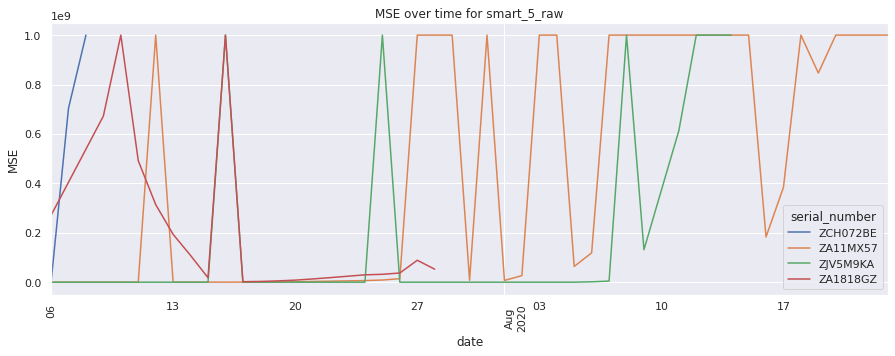

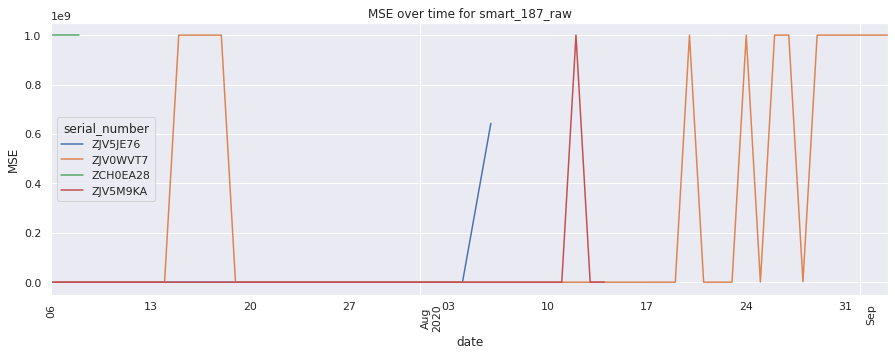

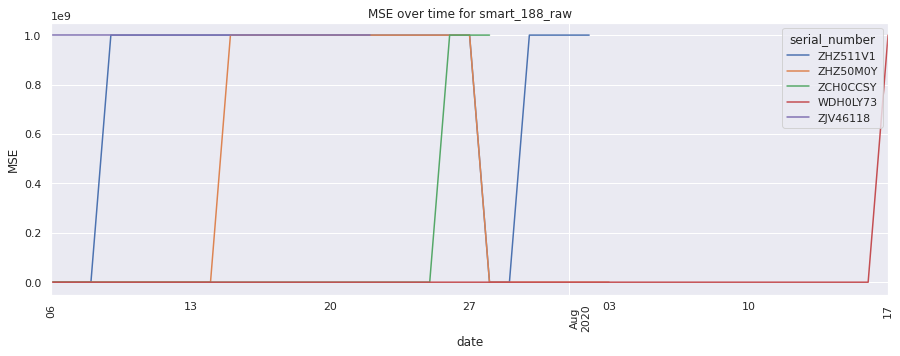

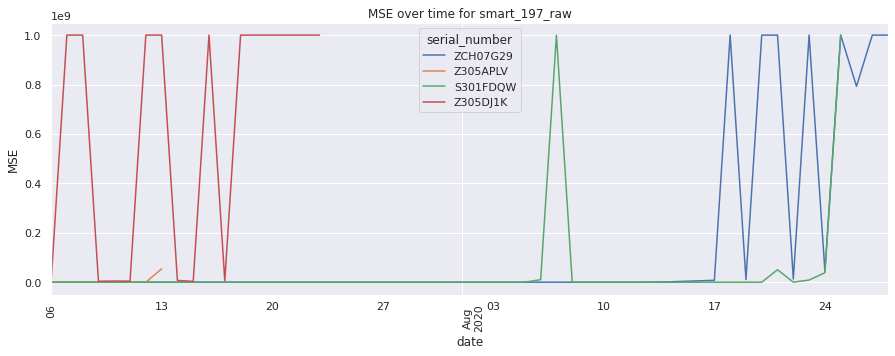

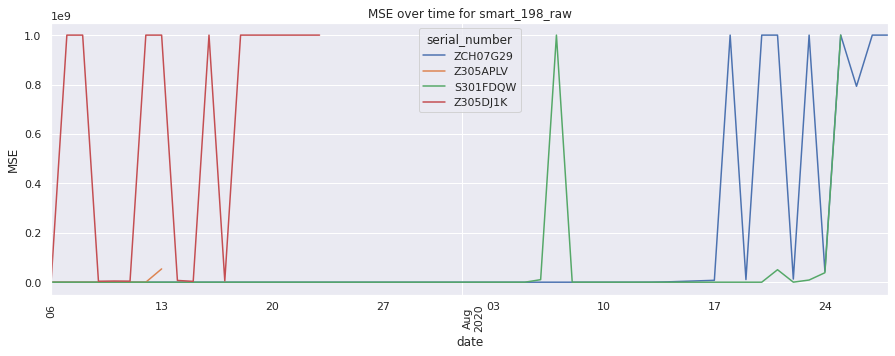

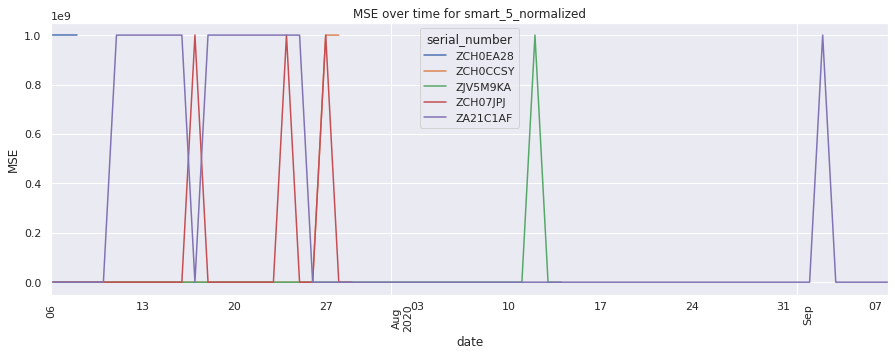

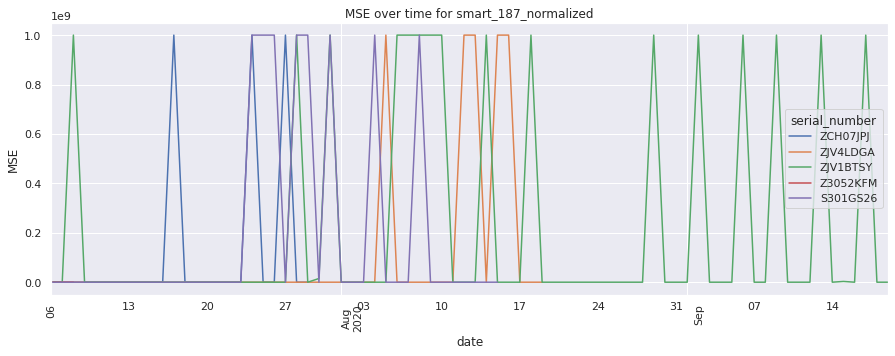

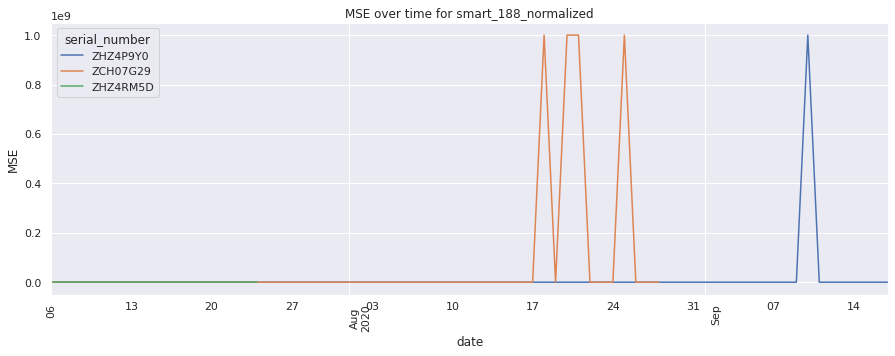

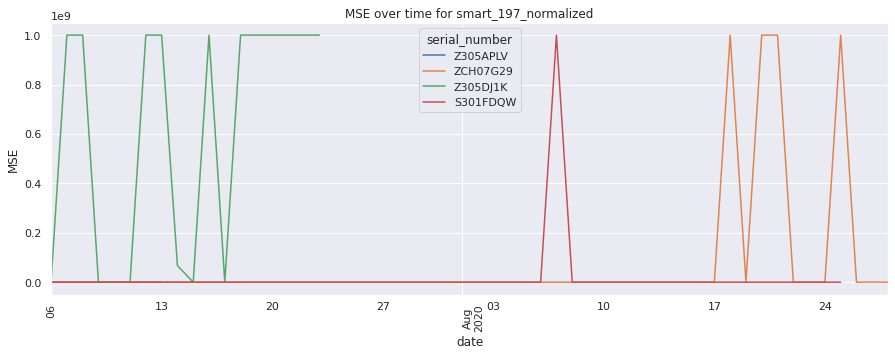

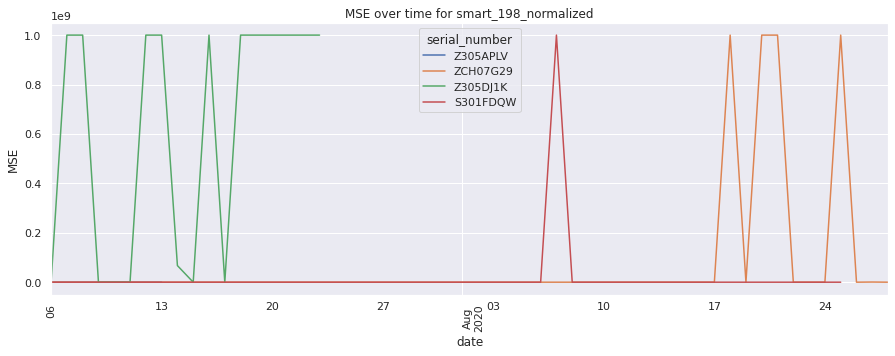

In [21]:
# visualize performance for time series with highest stds
plot_losses_metricwise(
    failedts_var_losses.clip(upper=1e9),
    failed_ts_df,
    loss_name="MSE",
    to_plot=5,
)

In [22]:
# improvement in mse in each train-predict window for each metric for each disk
diff = failedts_baseline_losses - failedts_var_losses
diff = diff[diff != -np.inf]

# average improvement for each disk
mean_diff = diff.mean(level=0)

# average value of average improvement (averaged across disks)
print('Average Value of "Mean Improvement Over Baseline in each Disk"')
display(mean_diff.mean())

# median improvement for each disk (mean more sensitive to outliers)
median_diff = diff.median(level=0)

# average value of median improvement (averaged across disks)
print('Average Value of "Median Improvement Over Baseline in each Disk"')
display(median_diff.mean())

Average Value of "Mean Improvement Over Baseline in each Disk"


smart_5_raw            -8.341426e+299
smart_187_raw          -1.861365e+258
smart_188_raw           -4.450201e+19
smart_197_raw          -1.094988e+191
smart_198_raw          -1.094988e+191
smart_5_normalized      -1.482136e+08
smart_187_normalized   -7.492974e+116
smart_188_normalized    -2.763527e-04
smart_197_normalized    -4.198421e+04
smart_198_normalized    -4.198421e+04
dtype: float64

Average Value of "Median Improvement Over Baseline in each Disk"


smart_5_raw            -1.300077e+06
smart_187_raw          -2.051255e+01
smart_188_raw          -9.037679e+16
smart_197_raw          -1.131348e+04
smart_198_raw          -1.131348e+04
smart_5_normalized     -8.155344e-02
smart_187_normalized   -3.166731e+00
smart_188_normalized    0.000000e+00
smart_197_normalized   -3.160538e-01
smart_198_normalized   -3.160538e-01
dtype: float64

### VARMAX
Training VARMAX gives the following errors:

- linalg matrix not positive definite error thrown when cov type = 'unstructured'
- linalg 1-th leading minor of the array is not positive definite thrown when cov type = 'diagonal'

These errors still remain unresolved, and it may be outside the scope of this short exploratory notebook to dive deep into VARMAX specifically. Nonetheless, the suspicion is that this is because the time series length is too less. If this is in fact the case, then it is unclear how to fix this.

### Conclusion

Based on the above results and issues, it seems that AR/MA models are not performing much better than the baseline. One of the key reasons for this may be that they have several assumptions regarding the data, and therefore need data to be pre-processed carefully. This should be explored in another notebook in detail, and the setup here should be updated to reflect the results from that notebook, i.e. the "best" preprocessing setup.

## Regression-based Models

In this section, we will use a simple multivariate regression setup. 

In [23]:
def get_model_windowwise_losses(
    drive_ts, model, sample_weight=None, ensemble=False, loss="mse"
):
    """
    Fit provided model and calculate loss
    for each ytrain-predict window the given drive
    """
    losses = pd.DataFrame(
        columns=Y_COLS,
        index=deepcopy(drive_ts.index),
        dtype=np.float,
    )

    # withstd=False because constant cols cause 0 std
    # which causes divide by zero errors
    scaler = StandardScaler(with_std=False)

    # dummy independent variable
    xtrain = np.arange(start=0, stop=NDAYS_DATA).reshape(-1, 1)

    for end_idx in range(NDAYS_DATA, len(drive_ts) - NDAYS_TO_PREDICT + 1):

        # historical NDAYS_DATA data
        ytrain = drive_ts[Y_COLS].iloc[end_idx - NDAYS_DATA : end_idx]

        ytrain = pd.DataFrame(
            scaler.fit_transform(ytrain.values),
            index=ytrain.index,
            columns=ytrain.columns,
        )

        # next NDAYS_TO_PREDICT data
        ytest = drive_ts[Y_COLS].iloc[end_idx : end_idx + NDAYS_TO_PREDICT]

        # dummy independent variables for forecasts
        xtest = np.arange(
            start=NDAYS_DATA,
            stop=NDAYS_DATA + len(ytest),
        ).reshape(-1, 1)

        # fit model
        if ensemble:
            model.fit(
                X=xtrain,
                Y=ytrain,
            )
        else:
            model.fit(
                X=xtrain,
                y=ytrain,
                sample_weight=sample_weight,
            )

        # forecast
        ypred = scaler.inverse_transform(model.predict(xtest))

        # calculate loss
        losses.iloc[end_idx - 1] = calculate_predictionwindow_loss(
            y_true=ytest,
            y_train=ytrain,
            y_pred=ypred,
        )

    return losses

### Linear Regression

In [24]:
# calculate linreg model performance
failedts_linreg_losses = failed_ts_df.groupby("serial_number").progress_apply(
    partial(
        get_model_windowwise_losses,
        model=LinearRegression(normalize=False),
    )
)

# drop rows where there are no results (coz not enough historical data)
failedts_linreg_losses.dropna(axis=0, how="all", inplace=True)

# add to results
all_losses.loc[:, midx[:, "linreg"]] = failedts_linreg_losses.dropna(how="all").values

# average mse across days
failedts_linreg_losses.mean(level=0)

100%|██████████| 251/251 [00:39<00:00,  6.33it/s]


,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_5_normalized,smart_187_normalized,smart_188_normalized,smart_197_normalized,smart_198_normalized
serial_number,,,,,,,,,,
S300Z4TZ,8.581553e+02,20.393515,1.780822e-01,9.438895e+04,9.438895e+04,0.002283,20.393515,0.0,3.410959,3.410959
S300Z7P1,0.000000e+00,0.184932,0.000000e+00,1.461187e-01,1.461187e-01,0.000000,0.184932,0.0,0.000000,0.000000
S301FDQW,5.151040e+06,257.826969,0.000000e+00,3.154284e+06,3.154284e+06,3.169935,99.777171,0.0,93.513072,93.513072
S301GMWQ,7.111111e+01,29.359728,0.000000e+00,1.582575e+02,1.582575e+02,0.000000,29.359728,0.0,0.000000,0.000000
S301GMY2,2.134537e+02,549.946840,0.000000e+00,1.802176e+05,1.802176e+05,0.000000,524.358961,0.0,5.870484,5.870484
...,...,...,...,...,...,...,...,...,...,...
ZLW0EFTW,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0EFYY,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0G6CE,0.000000e+00,1136.678571,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,116.678571,0.0,0.000000,0.000000


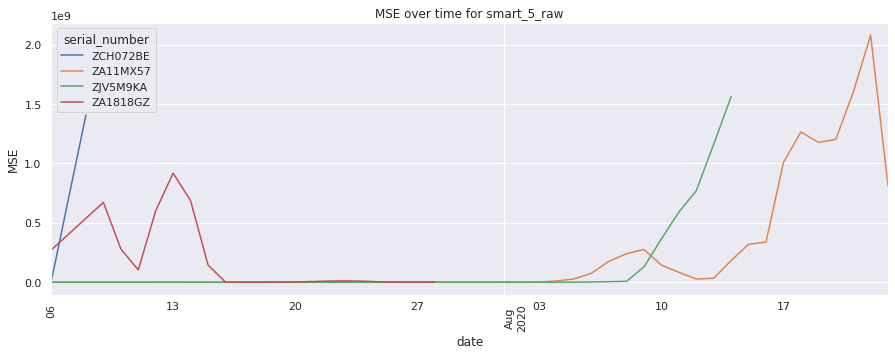

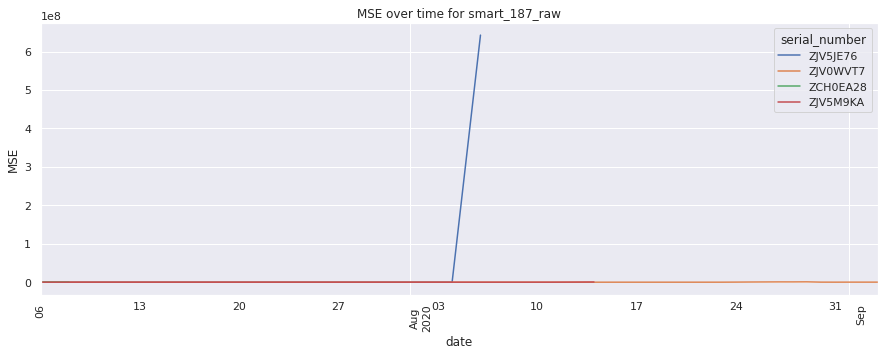

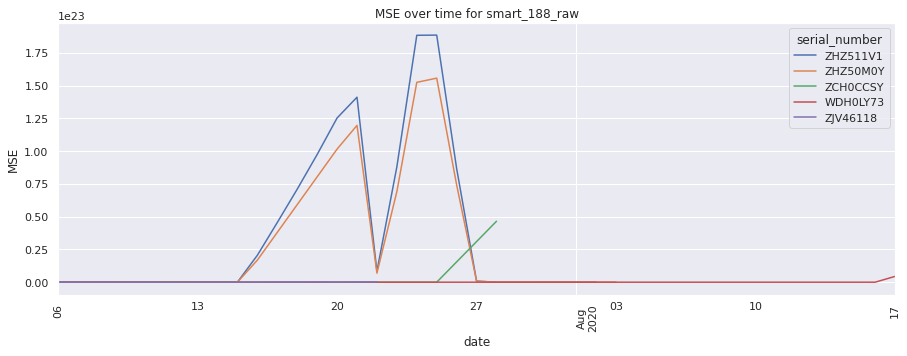

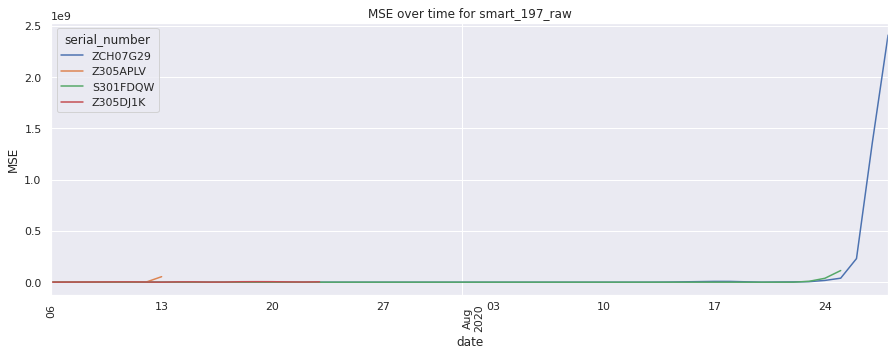

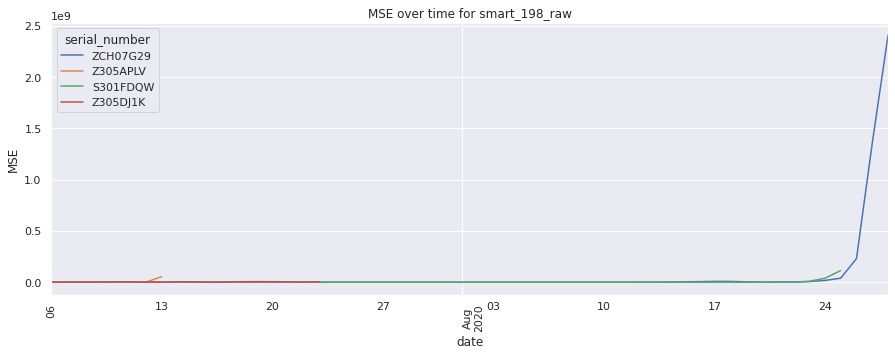

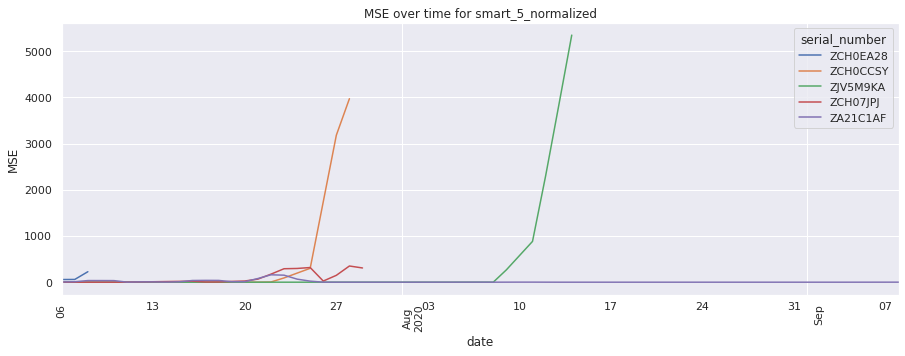

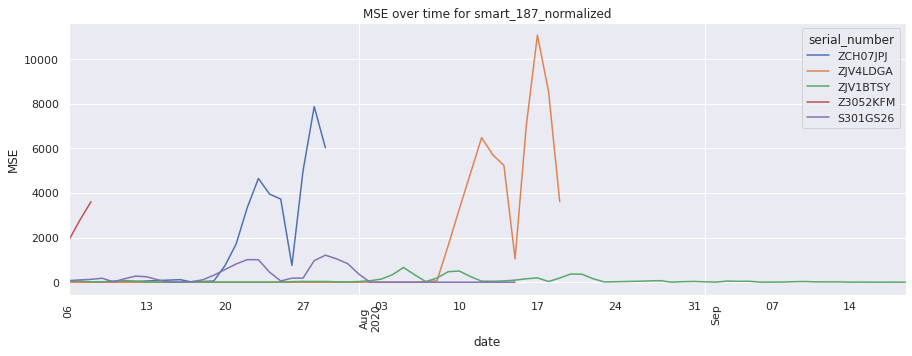

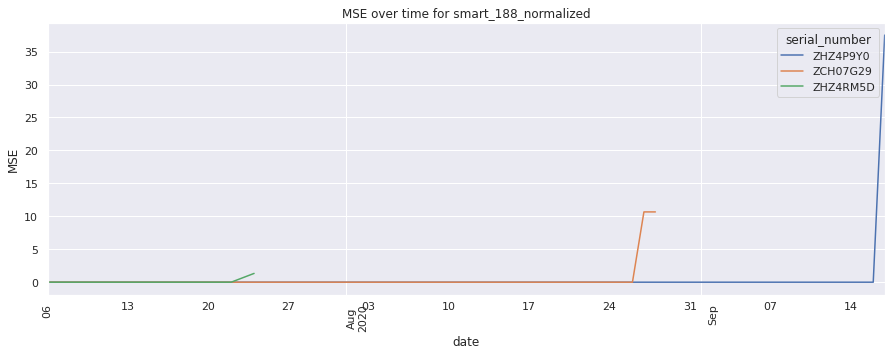

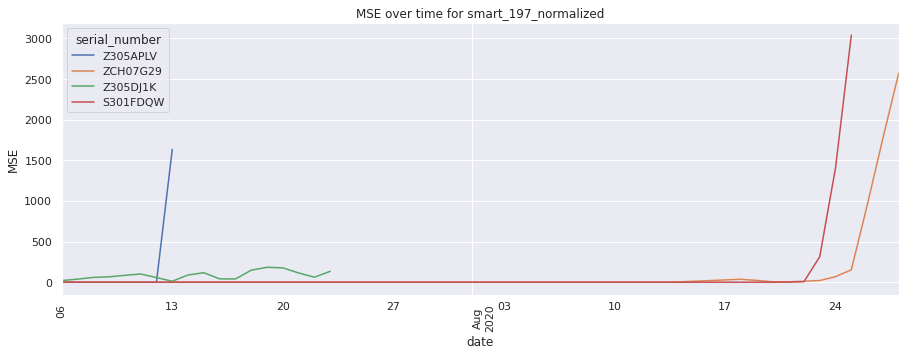

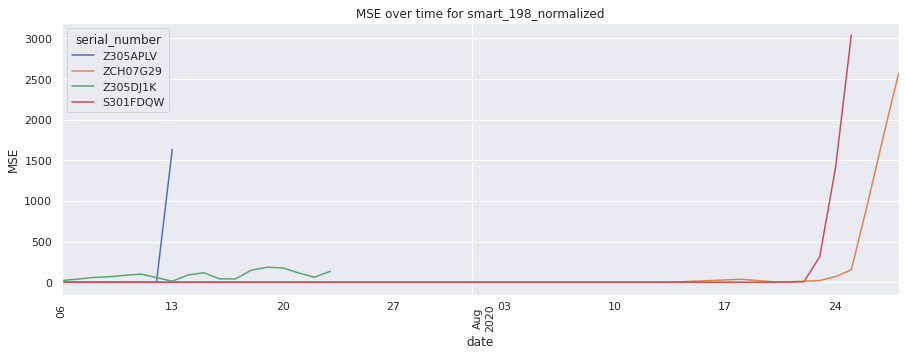

In [25]:
# visualize performance for time series with highest stds
plot_losses_metricwise(
    failedts_linreg_losses,  # .clip(upper=1e9),
    failed_ts_df,
    loss_name="MSE",
    to_plot=5,
)

In [26]:
# improvement in mse in each train-predict window for each metric for each disk
diff = failedts_baseline_losses - failedts_linreg_losses

# average improvement for each disk
mean_diff = diff.mean(level=0)

# average value of average improvement (averaged across disks)
print("Average Values of Mean Improvement in each Disk")
display(mean_diff.mean())
# display(mean_diff.describe())

# median improvement for each disk (mean more sensitive to outliers)
median_diff = diff.median(level=0)

# average value of median improvement (averaged across disks)
print("Average Values of Median Improvement in each Disk")
display(median_diff.mean())
# display(mean_diff.describe())

Average Values of Mean Improvement in each Disk


smart_5_raw            -1.137027e+07
smart_187_raw           3.582847e+02
smart_188_raw          -1.966733e+20
smart_197_raw          -3.591474e+03
smart_198_raw          -3.591474e+03
smart_5_normalized     -3.569326e-01
smart_187_normalized   -2.554944e+01
smart_188_normalized   -1.305862e-03
smart_197_normalized   -1.936507e-02
smart_198_normalized   -1.936507e-02
dtype: float64

Average Values of Median Improvement in each Disk


smart_5_raw            -1.458580e+06
smart_187_raw           2.545654e+02
smart_188_raw          -3.431324e+16
smart_197_raw           1.003322e+03
smart_198_raw           1.003322e+03
smart_5_normalized      1.045720e+00
smart_187_normalized   -3.452142e+00
smart_188_normalized    0.000000e+00
smart_197_normalized    3.796037e-02
smart_198_normalized    3.796037e-02
dtype: float64

### Weighted Linear Regression

In [27]:
# calculate weightedlinreg model performance

# twice the vanilla ols weighting then fall off exponentially
alpha = 2 * (1 / NDAYS_DATA)
exp_weights = [alpha * (1 - alpha) ** i for i in range(NDAYS_DATA - 1)] + [
    (1 - alpha) ** (NDAYS_DATA - 1)
]

failedts_weightedlinreg_losses = failed_ts_df.groupby("serial_number").progress_apply(
    partial(
        get_model_windowwise_losses,
        sample_weight=exp_weights,
        model=LinearRegression(normalize=False),
    )
)

# drop rows where there are no results (coz not enough historical data)
failedts_weightedlinreg_losses.dropna(axis=0, how="all", inplace=True)

# add to results
all_losses.loc[:, midx[:, "wlinreg"]] = failedts_weightedlinreg_losses.values

# average mse across days
failedts_weightedlinreg_losses.mean(level=0)

100%|██████████| 251/251 [00:42<00:00,  5.89it/s]


,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_5_normalized,smart_187_normalized,smart_188_normalized,smart_197_normalized,smart_198_normalized
serial_number,,,,,,,,,,
S300Z4TZ,8.581553e+02,20.646126,1.780822e-01,9.454581e+04,9.454581e+04,0.002283,20.646126,0.0,3.410959,3.410959
S300Z7P1,0.000000e+00,0.184932,0.000000e+00,1.461187e-01,1.461187e-01,0.000000,0.184932,0.0,0.000000,0.000000
S301FDQW,5.151040e+06,257.448289,0.000000e+00,3.151973e+06,3.151973e+06,3.169935,99.529557,0.0,93.513072,93.513072
S301GMWQ,7.111111e+01,29.221372,0.000000e+00,1.455299e+02,1.455299e+02,0.000000,29.221372,0.0,0.000000,0.000000
S301GMY2,2.134337e+02,540.200465,0.000000e+00,1.788971e+05,1.788971e+05,0.000000,516.064510,0.0,6.083748,6.083748
...,...,...,...,...,...,...,...,...,...,...
ZLW0EFTW,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0EFYY,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0G6CE,0.000000e+00,1136.678571,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,116.678571,0.0,0.000000,0.000000


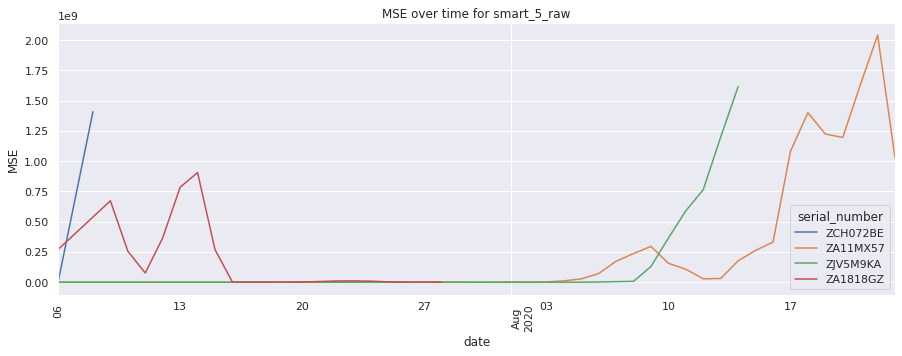

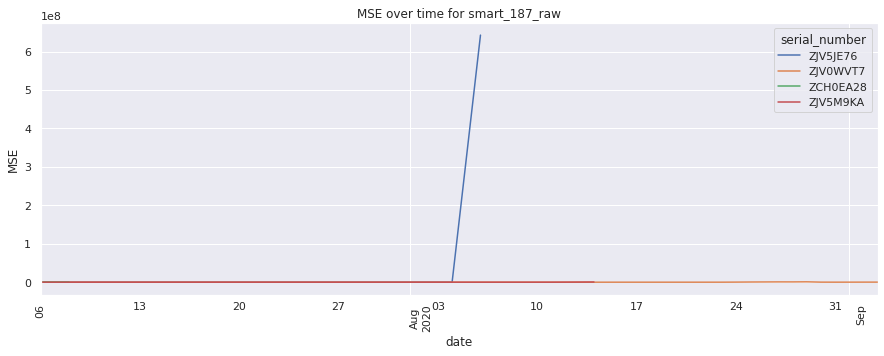

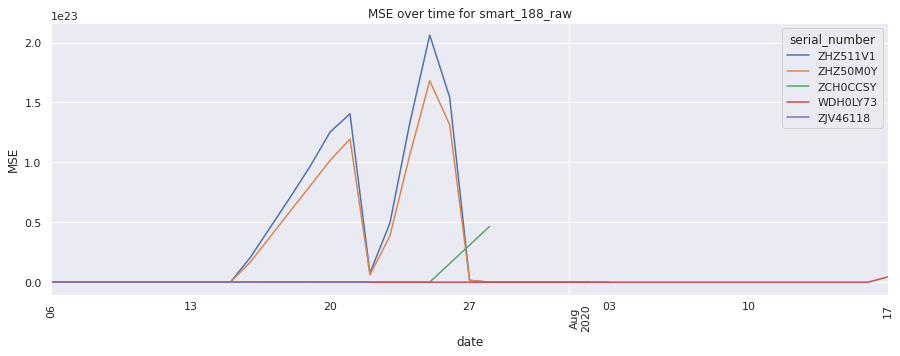

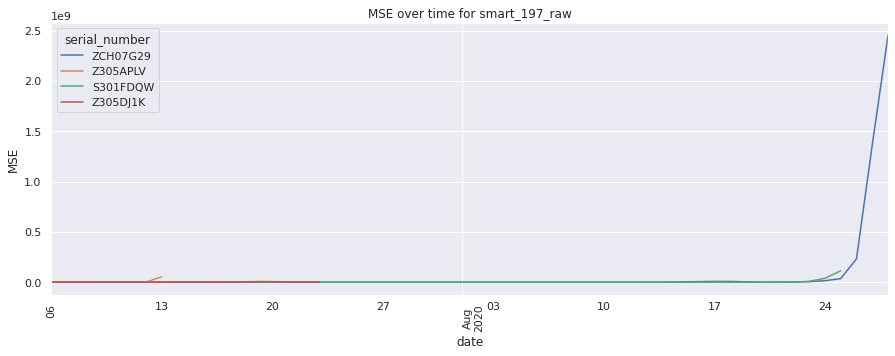

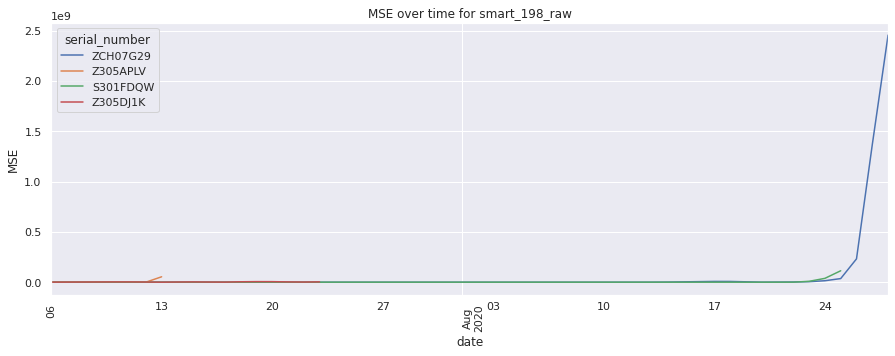

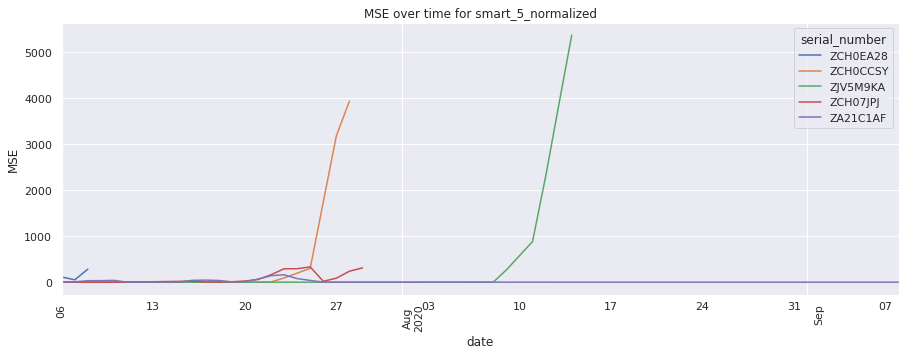

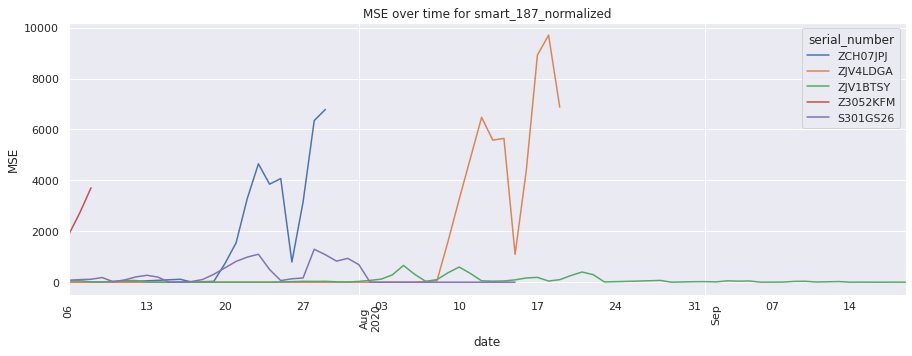

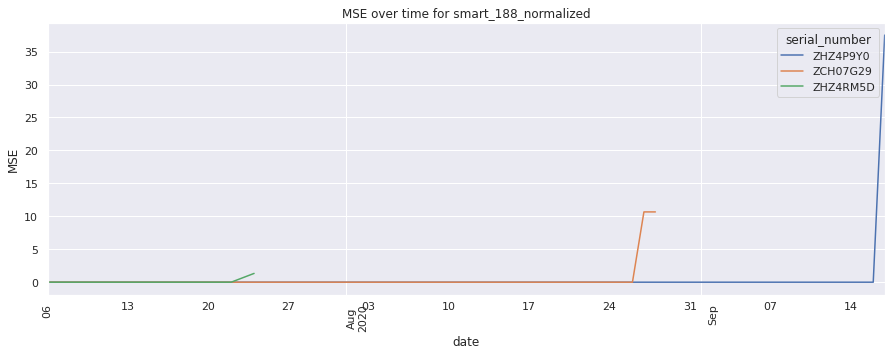

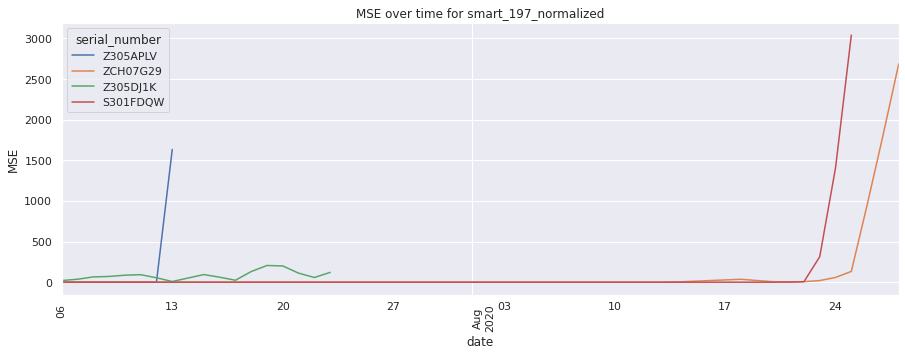

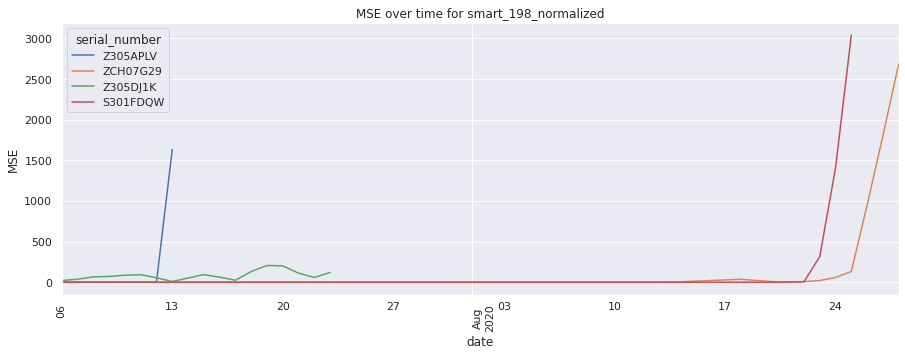

In [28]:
# visualize performance for time series with highest stds
plot_losses_metricwise(
    failedts_weightedlinreg_losses,  # .clip(upper=1e9),
    failed_ts_df,
    loss_name="MSE",
    to_plot=5,
)

In [29]:
# improvement in mse in each train-predict window for each metric for each disk
diff = failedts_baseline_losses - failedts_weightedlinreg_losses

# average improvement for each disk
mean_diff = diff.mean(level=0)

# average value of average improvement (averaged across disks)
print("Average Value of Mean Improvement in each Disk")
display(mean_diff.mean())

# median improvement for each disk (mean more sensitive to outliers)
median_diff = diff.median(level=0)

# average value of median improvement (averaged across disks)
print("Average Value of Median Improvement in each Disk")
display(median_diff.mean())

Average Value of Mean Improvement in each Disk


smart_5_raw            -9.976458e+06
smart_187_raw           3.139324e+02
smart_188_raw          -1.938747e+20
smart_197_raw          -7.024850e+03
smart_198_raw          -7.024850e+03
smart_5_normalized     -4.631586e-01
smart_187_normalized   -2.617826e+01
smart_188_normalized   -1.244639e-03
smart_197_normalized   -1.755865e-02
smart_198_normalized   -1.755865e-02
dtype: float64

Average Value of Median Improvement in each Disk


smart_5_raw            -6.270182e+04
smart_187_raw           2.376183e+02
smart_188_raw          -3.097224e+16
smart_197_raw           8.814337e+02
smart_198_raw           8.814337e+02
smart_5_normalized      1.080764e+00
smart_187_normalized   -5.918697e+00
smart_188_normalized    0.000000e+00
smart_197_normalized    1.301456e-02
smart_198_normalized    1.301456e-02
dtype: float64

### Thielsen Regression

In [30]:
# calculate thielsenreg model performance
with ignore_warnings("ConvergenceWarning"):
    failedts_thielsenreg_losses = failed_ts_df.groupby("serial_number").progress_apply(
        partial(
            get_model_windowwise_losses,
            ensemble=True,
            model=RegressorChain(TheilSenRegressor(random_state=0)),
        )
    )

# drop rows where there are no results (coz not enough historical data)
failedts_thielsenreg_losses.dropna(axis=0, how="all", inplace=True)

# add to results
all_losses.loc[:, midx[:, "theilsen"]] = failedts_thielsenreg_losses.values

# average mse across days
failedts_thielsenreg_losses.mean(level=0)

100%|██████████| 251/251 [02:05<00:00,  1.99it/s]


,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_5_normalized,smart_187_normalized,smart_188_normalized,smart_197_normalized,smart_198_normalized
serial_number,,,,,,,,,,
S300Z4TZ,8.581553e+02,23.216550,1.780822e-01,9.452724e+04,9.452724e+04,0.002283,23.216552,0.0,3.410959,3.410959
S300Z7P1,0.000000e+00,0.184932,0.000000e+00,1.461187e-01,1.461187e-01,0.000000,0.184932,0.0,0.000000,0.000000
S301FDQW,5.151040e+06,264.413990,0.000000e+00,3.163818e+06,3.163818e+06,3.169935,103.763045,0.0,93.513072,93.513072
S301GMWQ,7.111111e+01,42.067287,0.000000e+00,1.929439e+02,1.929438e+02,0.000000,42.067297,0.0,0.000000,0.000000
S301GMY2,2.154629e+02,677.855914,0.000000e+00,1.837094e+05,1.837094e+05,0.000000,646.049906,0.0,5.941418,5.941418
...,...,...,...,...,...,...,...,...,...,...
ZLW0EFTW,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0EFYY,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0G6CE,0.000000e+00,1136.678571,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,116.678571,0.0,0.000000,0.000000


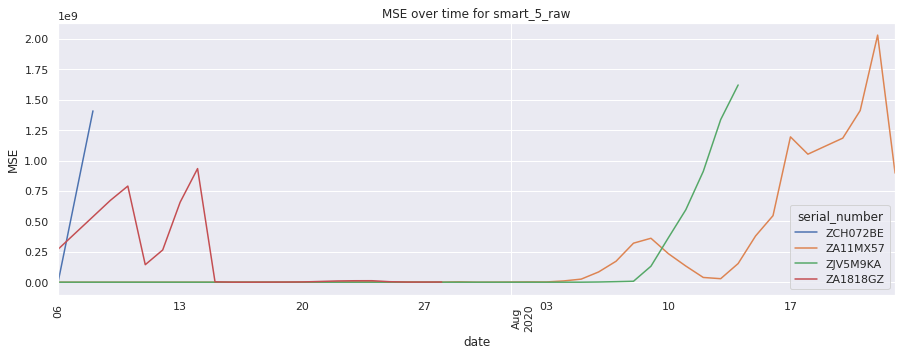

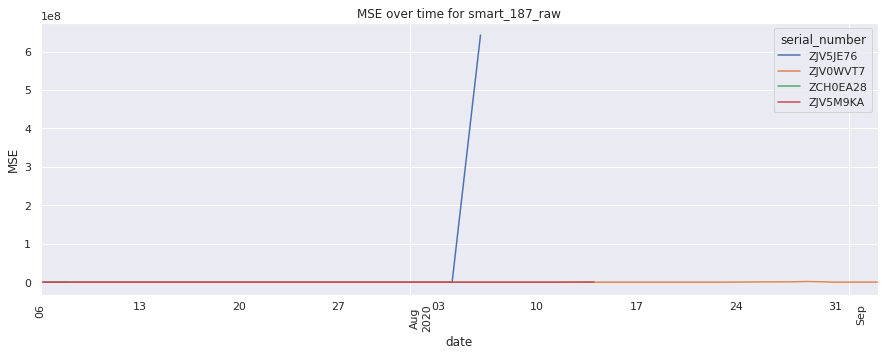

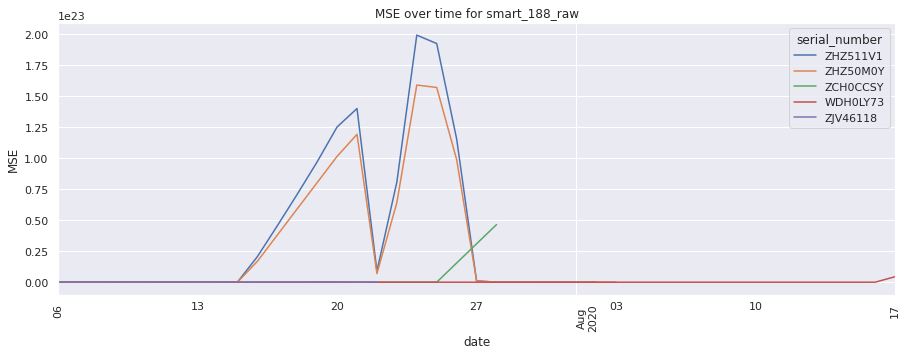

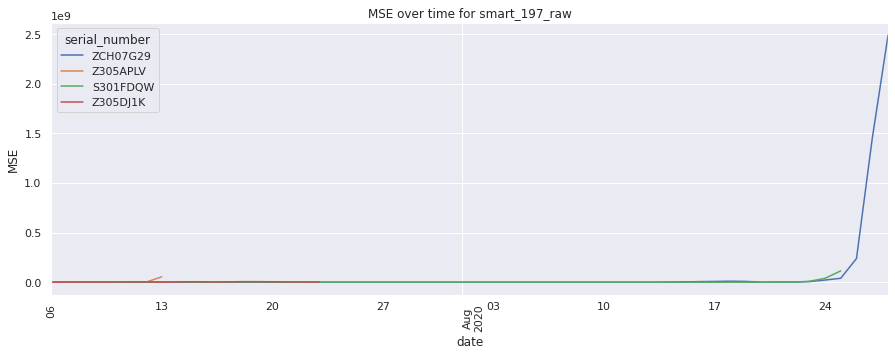

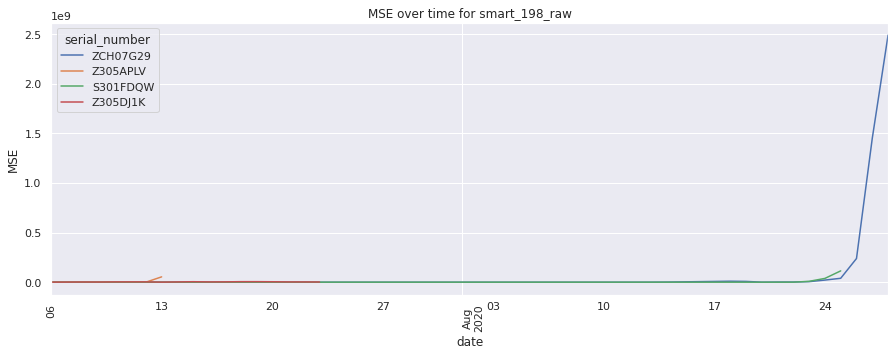

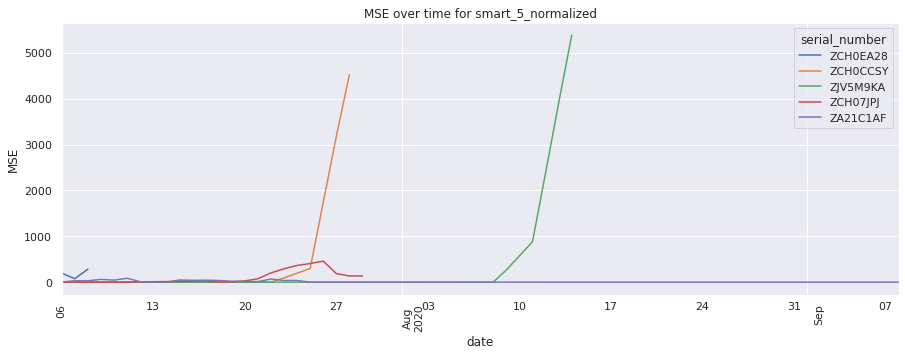

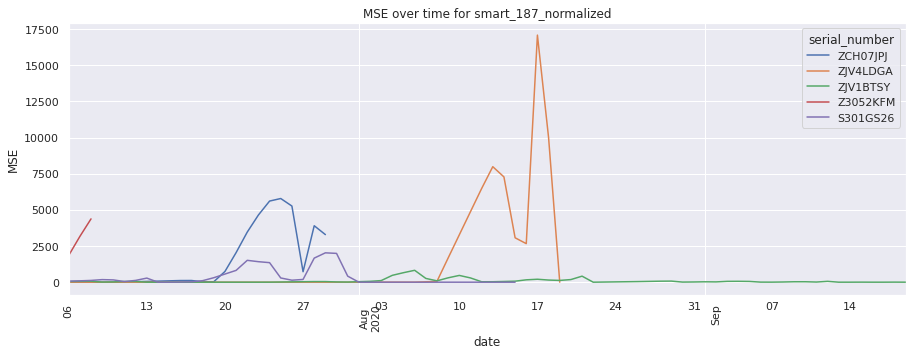

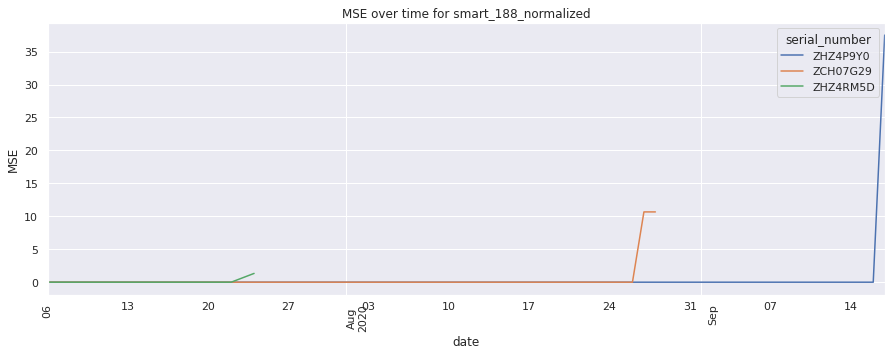

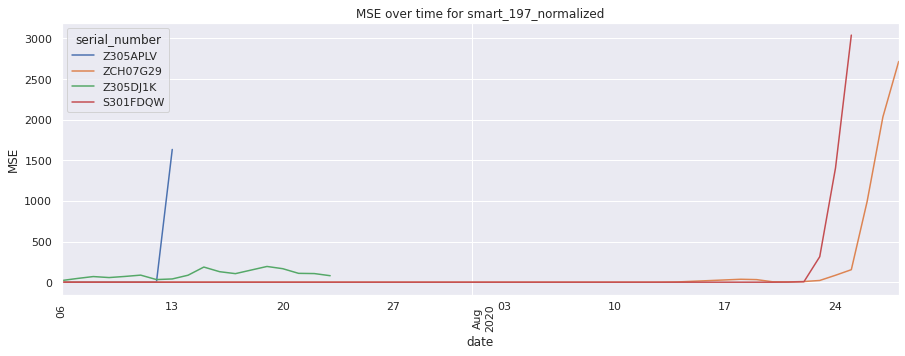

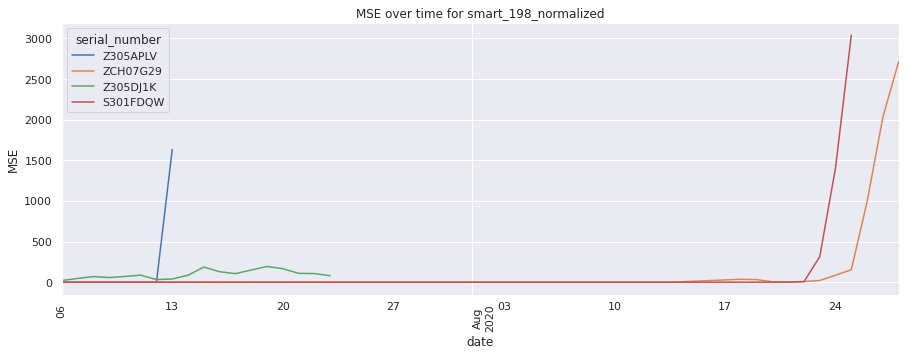

In [31]:
# visualize performance for time series with highest stds
plot_losses_metricwise(
    failedts_thielsenreg_losses,  # .clip(upper=1e9),
    failed_ts_df,
    loss_name="MSE",
    to_plot=5,
)

In [32]:
# improvement in mse in each train-predict window for each metric for each disk
diff = failedts_baseline_losses - failedts_thielsenreg_losses

# average improvement for each disk
mean_diff = diff.mean(level=0)

# average value of average improvement (averaged across disks)
print("Average Value of Mean Improvement in each Disk")
display(mean_diff.mean())

# median improvement for each disk (mean more sensitive to outliers)
median_diff = diff.median(level=0)

# average value of median improvement (averaged across disks)
print("Average Value of Median Improvement in each Disk")
display(median_diff.mean())

Average Value of Mean Improvement in each Disk


smart_5_raw            -1.217162e+07
smart_187_raw           1.033339e+02
smart_188_raw          -2.065577e+20
smart_197_raw          -2.116114e+04
smart_198_raw          -2.116114e+04
smart_5_normalized     -9.081443e-01
smart_187_normalized   -3.247315e+01
smart_188_normalized   -2.274886e-03
smart_197_normalized   -1.070564e-01
smart_198_normalized   -1.070564e-01
dtype: float64

Average Value of Median Improvement in each Disk


smart_5_raw            -3.229634e+06
smart_187_raw           2.612443e+02
smart_188_raw          -2.148367e+16
smart_197_raw          -2.208242e+03
smart_198_raw          -2.208242e+03
smart_5_normalized      9.702554e-01
smart_187_normalized   -4.479546e+00
smart_188_normalized    0.000000e+00
smart_197_normalized   -4.272601e-02
smart_198_normalized   -4.272601e-02
dtype: float64

### Decision Tree Regression

In [33]:
# calculate dt model performance
failedts_dt_losses = failed_ts_df.groupby("serial_number").progress_apply(
    partial(
        get_model_windowwise_losses,
        model=DecisionTreeRegressor(random_state=0),
    )
)

# drop rows where there are no results (coz not enough historical data)
failedts_dt_losses.dropna(axis=0, how="all", inplace=True)

# add to results
all_losses.loc[:, midx[:, "dt"]] = failedts_dt_losses.values

# average mse across days
failedts_dt_losses.mean(level=0)

100%|██████████| 251/251 [00:42<00:00,  5.90it/s]


,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_5_normalized,smart_187_normalized,smart_188_normalized,smart_197_normalized,smart_198_normalized
serial_number,,,,,,,,,,
S300Z4TZ,8.581553e+02,20.340183,0.178082,9.505666e+04,9.505666e+04,0.002283,20.340183,0.0,3.410959,3.410959
S300Z7P1,0.000000e+00,0.184932,0.000000,1.461187e-01,1.461187e-01,0.000000,0.184932,0.0,0.000000,0.000000
S301FDQW,5.151040e+06,256.820261,0.000000,3.160479e+06,3.160479e+06,3.169935,98.088235,0.0,93.513072,93.513072
S301GMWQ,7.111111e+01,34.000000,0.000000,1.280000e+02,1.280000e+02,0.000000,34.000000,0.0,0.000000,0.000000
S301GMY2,1.396364e+02,491.848485,0.000000,1.727370e+05,1.727370e+05,0.000000,441.272727,0.0,6.545455,6.545455
...,...,...,...,...,...,...,...,...,...,...
ZLW0EFTW,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0EFYY,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0G6CE,0.000000e+00,1136.678571,0.000000,0.000000e+00,0.000000e+00,0.000000,116.678571,0.0,0.000000,0.000000


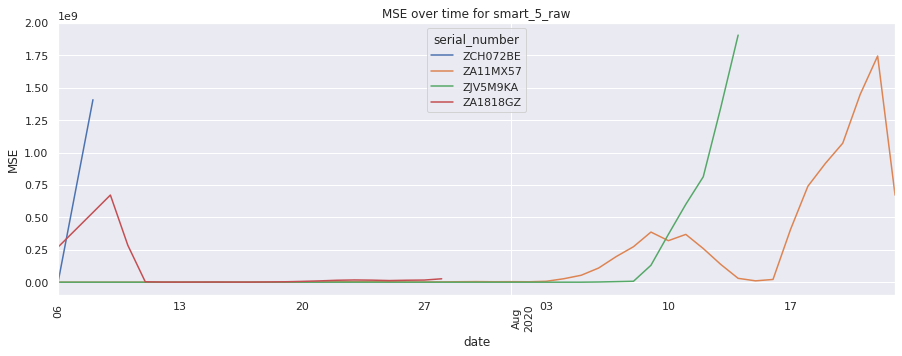

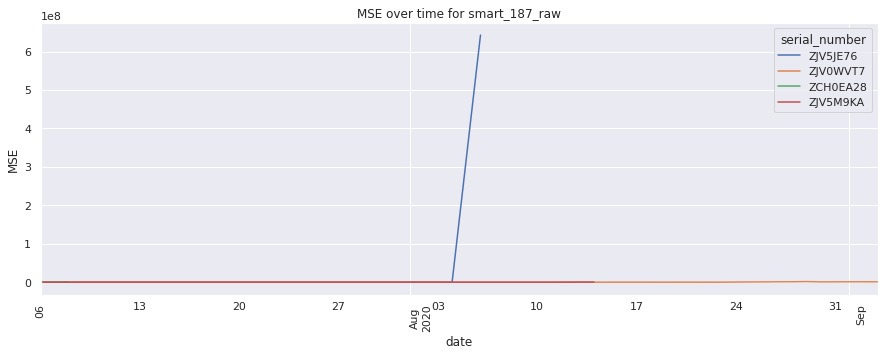

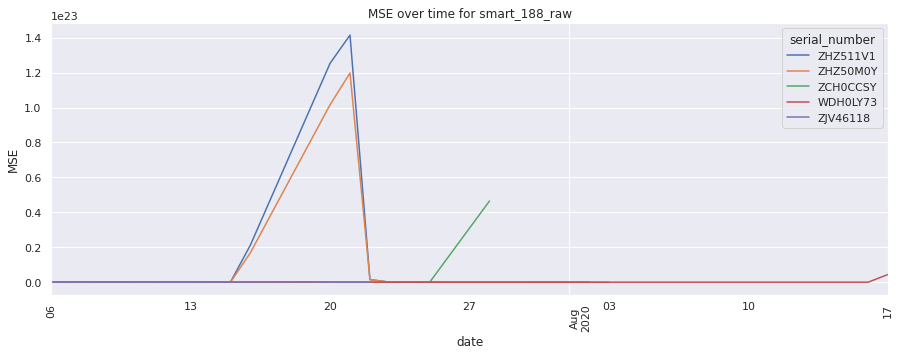

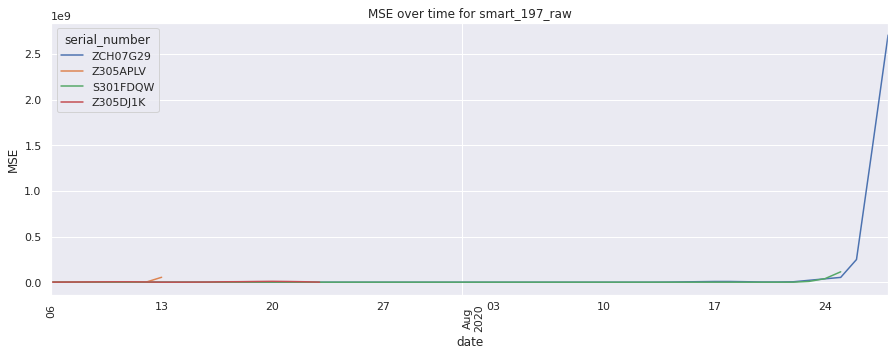

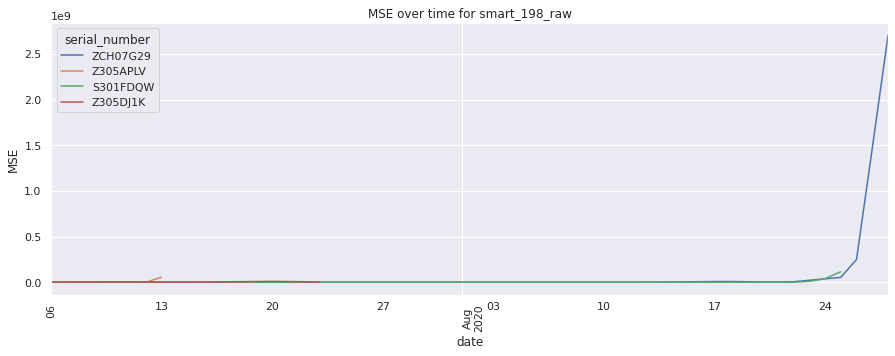

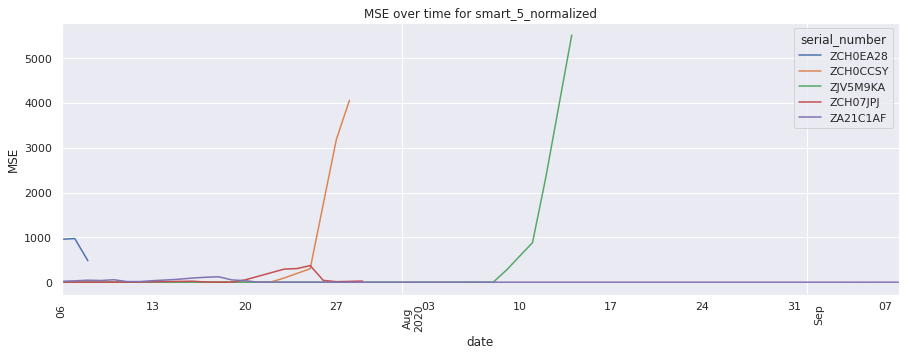

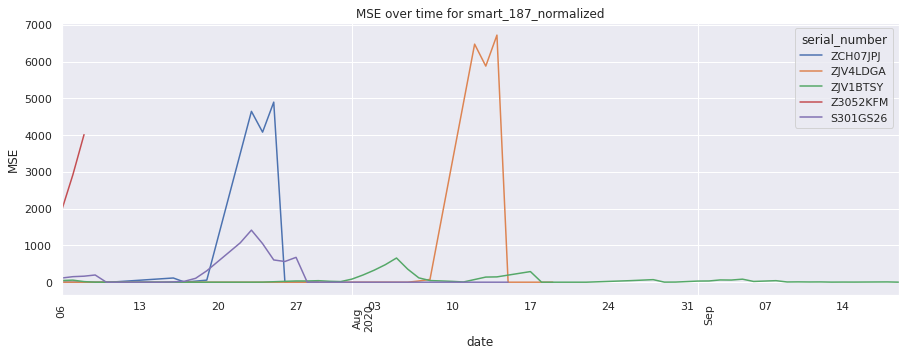

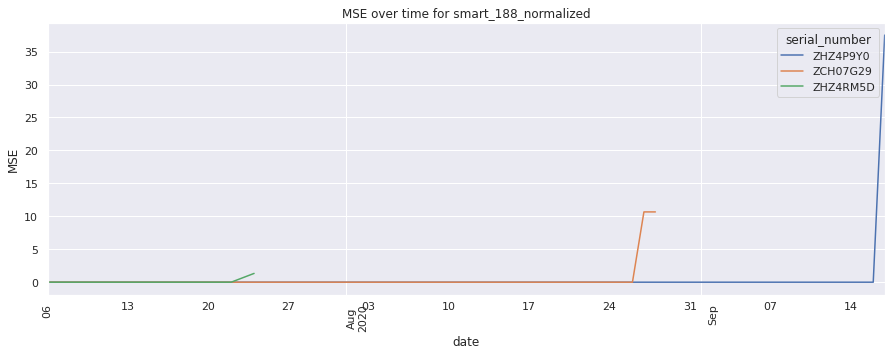

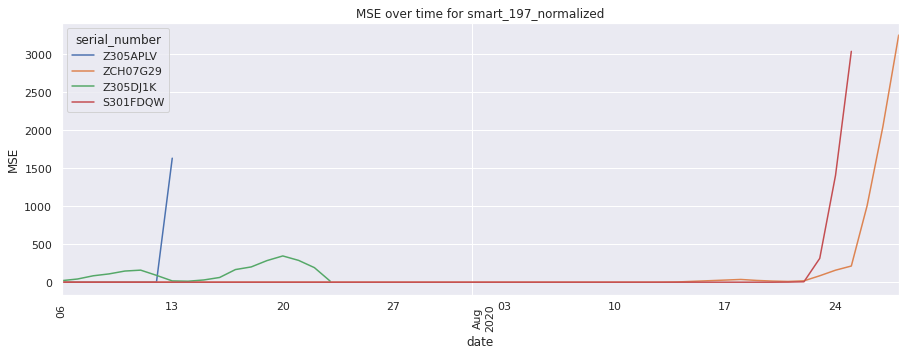

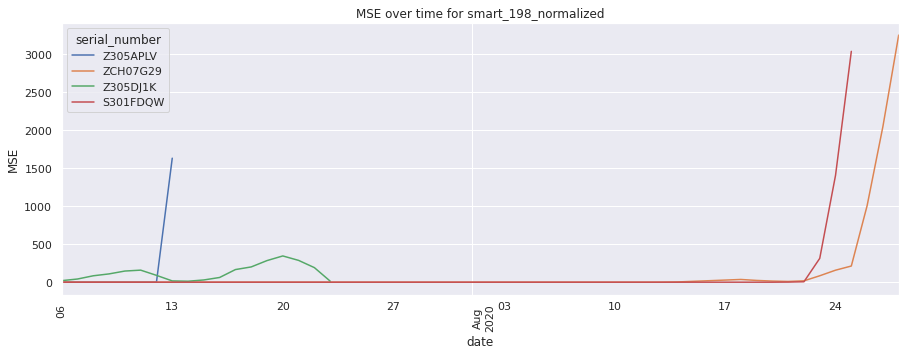

In [34]:
# visualize performance for time series with highest stds
plot_losses_metricwise(
    failedts_dt_losses,  # .clip(upper=1e9),
    failed_ts_df,
    loss_name="MSE",
    to_plot=5,
)

In [35]:
# improvement in mse in each train-predict window for each metric for each disk
diff = failedts_baseline_losses - failedts_dt_losses

# average improvement for each disk
mean_diff = diff.mean(level=0)

# average value of average improvement (averaged across disks)
print("Average Value of Mean Improvement in each Disk")
display(mean_diff.mean())

# median improvement for each disk (mean more sensitive to outliers)
median_diff = diff.median(level=0)

# average value of median improvement (averaged across disks)
print("Average Value of Median Improvement in each Disk")
display(median_diff.mean())

Average Value of Mean Improvement in each Disk


smart_5_raw            -2.241499e+06
smart_187_raw          -7.816148e+02
smart_188_raw          -4.179715e+19
smart_197_raw          -4.624460e+04
smart_198_raw          -4.624460e+04
smart_5_normalized     -3.057644e+00
smart_187_normalized   -1.048421e+01
smart_188_normalized   -2.557545e-04
smart_197_normalized   -2.952357e-01
smart_198_normalized   -2.952357e-01
dtype: float64

Average Value of Median Improvement in each Disk


smart_5_raw            -483235.344928
smart_187_raw             -390.497101
smart_188_raw               -0.026087
smart_197_raw            -1989.008696
smart_198_raw            -1989.008696
smart_5_normalized          -1.657971
smart_187_normalized        -1.045652
smart_188_normalized         0.000000
smart_197_normalized        -0.072464
smart_198_normalized        -0.072464
dtype: float64

### Random Forest Regresson

In [37]:
# calculate rf model performance
failedts_rf_losses = failed_ts_df.groupby("serial_number").progress_apply(
    partial(
        get_model_windowwise_losses,
        ensemble=True,
        model=RegressorChain(
            RandomForestRegressor(
                n_estimators=5,
                random_state=0,
            )
        ),
    )
)

# drop rows where there are no results (coz not enough historical data)
failedts_rf_losses.dropna(axis=0, how="all", inplace=True)

# add to results
all_losses.loc[:, midx[:, "rf"]] = failedts_rf_losses.values

# average mse across days
failedts_rf_losses.mean(level=0)

100%|██████████| 251/251 [09:32<00:00,  2.28s/it]


,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_5_normalized,smart_187_normalized,smart_188_normalized,smart_197_normalized,smart_198_normalized
serial_number,,,,,,,,,,
S300Z4TZ,8.581553e+02,20.735799,0.178082,9.507050e+04,9.507050e+04,0.002283,20.735799,0.0,3.410959,3.410959
S300Z7P1,0.000000e+00,0.184932,0.000000,1.461187e-01,1.461187e-01,0.000000,0.184932,0.0,0.000000,0.000000
S301FDQW,5.151040e+06,257.892418,0.000000,3.162283e+06,3.162284e+06,3.169935,98.763791,0.0,93.513072,93.513072
S301GMWQ,7.111111e+01,35.440000,0.000000,1.297067e+02,1.297067e+02,0.000000,35.440000,0.0,0.000000,0.000000
S301GMY2,1.396364e+02,507.975758,0.000000,1.739593e+05,1.739502e+05,0.000000,457.880000,0.0,6.603636,6.603636
...,...,...,...,...,...,...,...,...,...,...
ZLW0EFTW,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0EFYY,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
ZLW0G6CE,0.000000e+00,1136.678571,0.000000,0.000000e+00,0.000000e+00,0.000000,116.678571,0.0,0.000000,0.000000


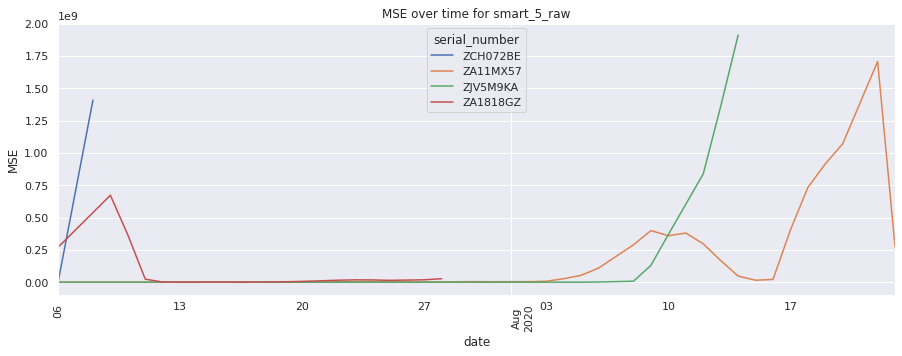

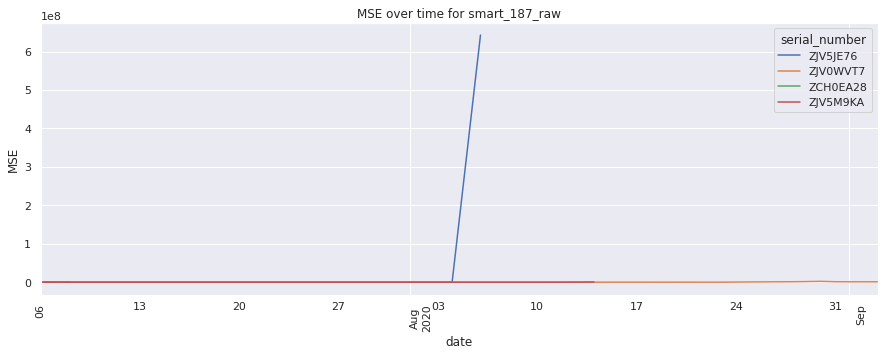

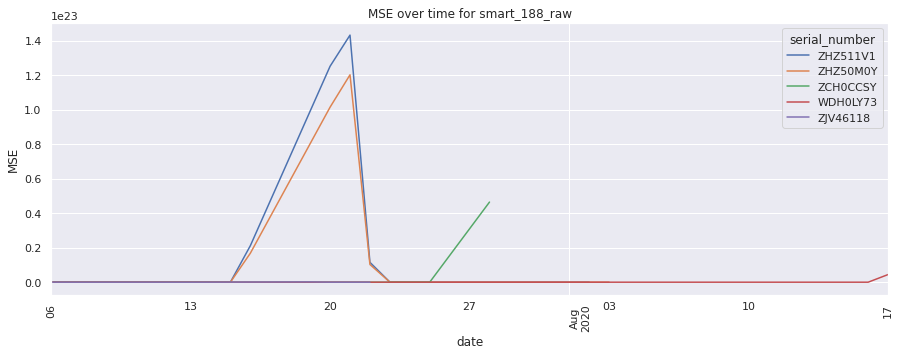

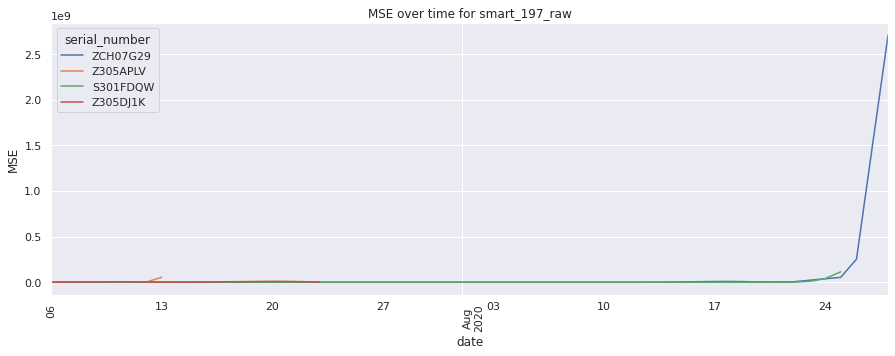

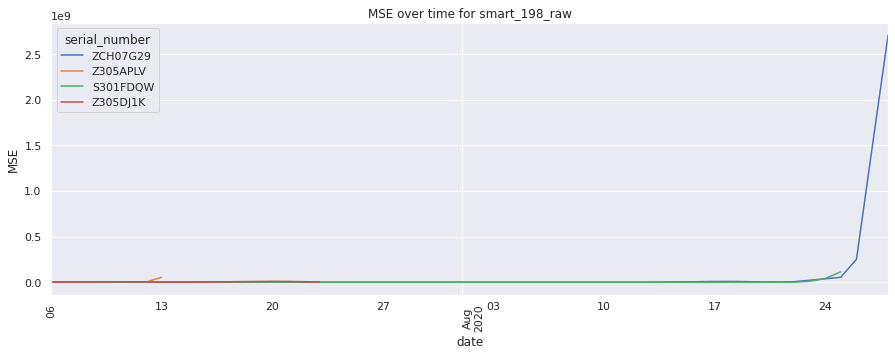

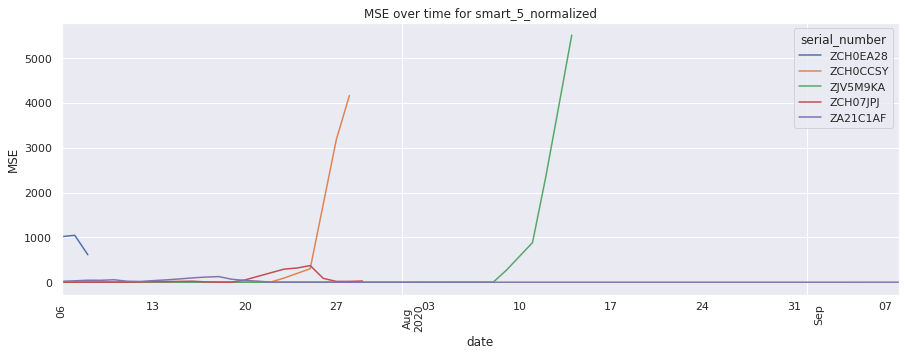

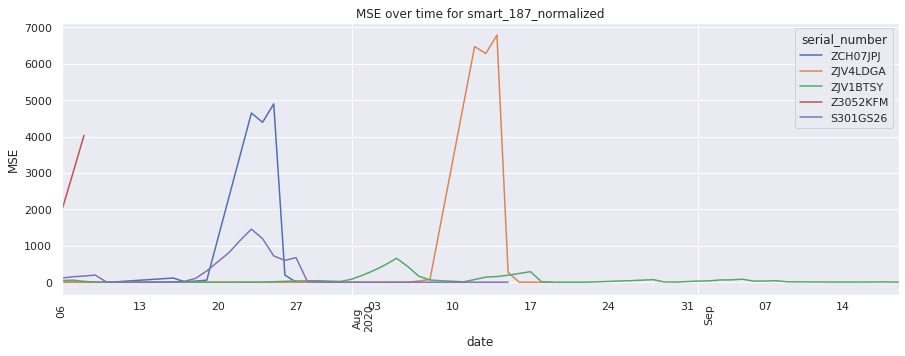

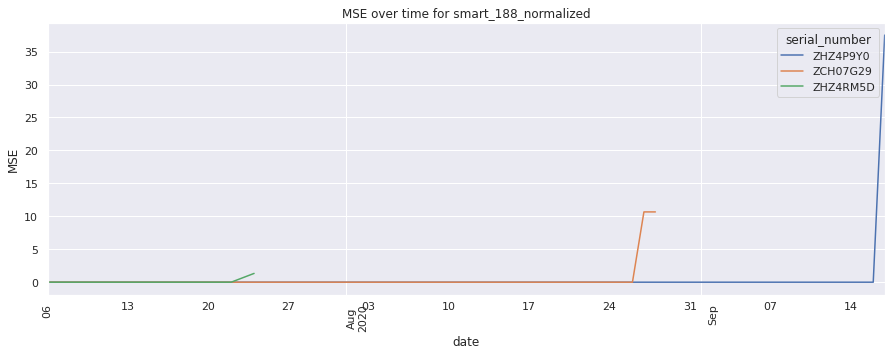

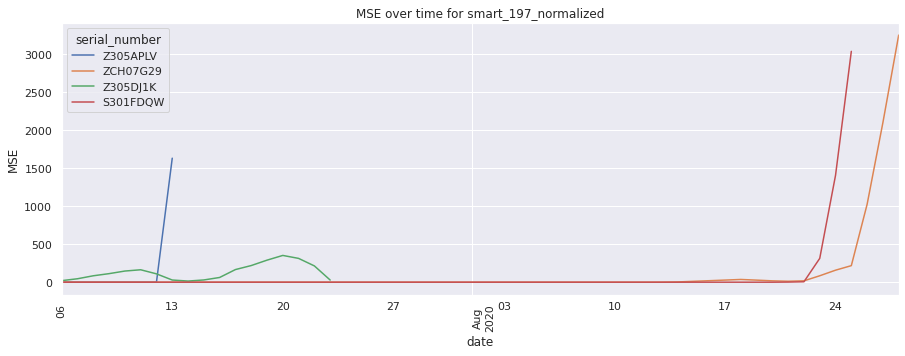

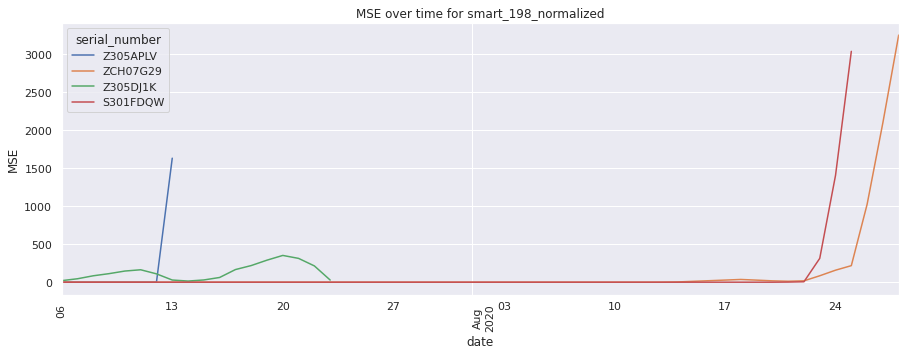

In [38]:
# visualize performance for time series with highest stds
plot_losses_metricwise(
    failedts_rf_losses,  # .clip(upper=1e9),
    failed_ts_df,
    loss_name="MSE",
    to_plot=5,
)

In [39]:
# improvement in mse in each train-predict window for each metric for each disk
diff = failedts_baseline_losses - failedts_rf_losses

# average improvement for each disk
mean_diff = diff.mean(level=0)

# average value of average improvement (averaged across disks)
print("Average Value of Mean Improvement in each Disk")
display(mean_diff.mean())

# median improvement for each disk (mean more sensitive to outliers)
median_diff = diff.median(level=0)

# average value of median improvement (averaged across disks)
print("Average Value of Median Improvement in each Disk")
display(median_diff.mean())

Average Value of Mean Improvement in each Disk


smart_5_raw            -2.206260e+06
smart_187_raw          -1.036388e+03
smart_188_raw          -4.508994e+19
smart_197_raw          -4.961732e+04
smart_198_raw          -4.961725e+04
smart_5_normalized     -3.513989e+00
smart_187_normalized   -1.156945e+01
smart_188_normalized   -2.330207e-04
smart_197_normalized   -3.359795e-01
smart_198_normalized   -3.359795e-01
dtype: float64

Average Value of Median Improvement in each Disk


smart_5_raw            -353433.650899
smart_187_raw             -535.006058
smart_188_raw               -0.042783
smart_197_raw            -2795.597913
smart_198_raw            -2795.052522
smart_5_normalized          -2.235072
smart_187_normalized        -1.354406
smart_188_normalized         0.000000
smart_197_normalized        -0.092232
smart_198_normalized        -0.092232
dtype: float64

# Conclusion

The results above suggest that an exponentially weighted linear regression model outperforms the rest of the models considered here. Still, the performance improvement over baseline is not too high, and also varies across the SMART metrics. This can be somewhat explained by the fact that we're using the average MSE across disks as our performance indicator, and the MSE for a small amount of disks is extremely high (thus skewing the "average performance gain" towards less than 0).

Also, it should be noted that the AR/MA model performance is quite sensitive to the dataset properties, especially given that the number of training data points available at run time is only 6. Therefore, one of the next steps should be to figuring out the optimal preprocessing steps to use in such models by exploring various preprocessing techniques in detail.